In [1]:
# Importing necessary libraries and general settings

import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

In [2]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


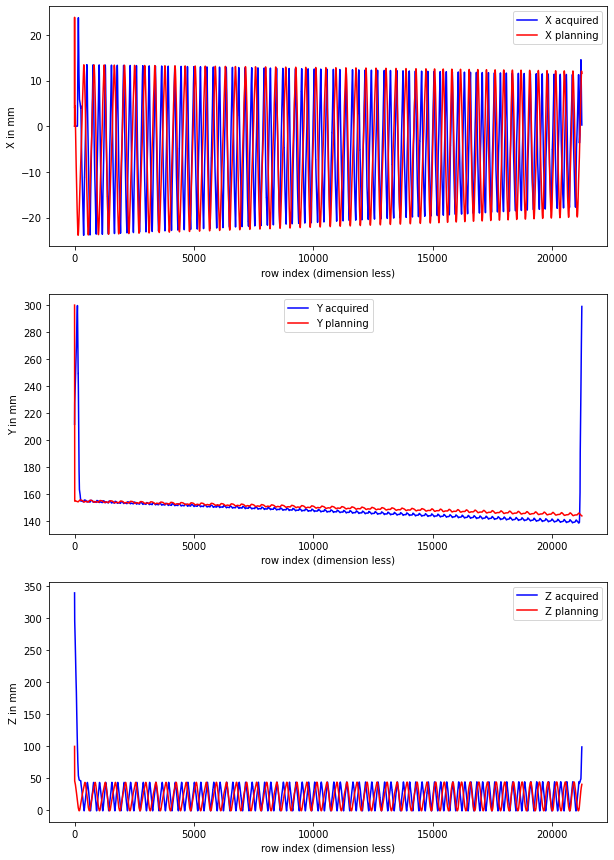

In [3]:
df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/96-6030-0.parquet')
#df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/0-1030-0.parquet')
block = 6030
angle = 96-15
df_p = pd.read_csv('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Toolpath/OP6030_TD_and_WD.csv',delimiter= ';')

df_m = df_m.rename(columns=df_m.iloc[0])
df_m = df_m.iloc[1: , :]

tool_tip_X = df_p['X_TTP Q [mm]'].to_numpy()
tool_tip_Y = df_p['Y_TTP  [mm]'].to_numpy()
tool_tip_Z = df_p['Z_TTP  [mm]'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

wcx = pd.to_numeric(df_m['DynamicData     WcX']).to_numpy()
wcy = pd.to_numeric(df_m['DynamicData     WcY']).to_numpy()
wcz = pd.to_numeric(df_m['DynamicData     WcZ']).to_numpy()

size = wcx.shape[0]
ones = np.ones((size,))
zeros = np.zeros((size,))

init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

forward_transformation = np.transpose(init_C, (2,0,1))
tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]

subplotter(0,Y.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)

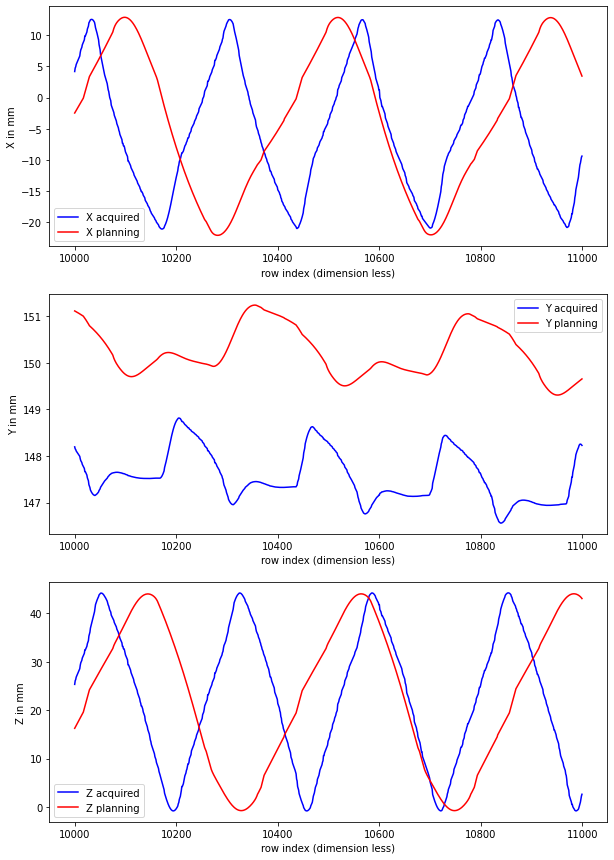

In [4]:
subplotter(10000,11000,X,Y,Z,X_inv,Y_inv,Z_inv)

In [5]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
#tol = input()
tol = 3
count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

Enter the tolerance number value, example 3 mm
243 7 2.770283056889471 1
244 7 2.770283056889471 2
245 7 2.423504783484076 3
246 7 2.3088213118204206 4
247 7 2.1946896594977354 5
248 7 2.081220384711561 6
249 7 1.9685406084789219 7
250 7 1.856763117847747 8
251 7 1.621710600561423 9
252 7 1.4086838338917502 10
253 7 1.3056787831040089 11
254 7 1.2058223902964977 12
255 7 1.1099752574108626 13
256 7 0.8595909854348791 14
257 7 0.7950554540120897 15
258 7 0.7443998240142083 16
259 7 0.7105995046781919 17
260 7 0.6210072194903401 18
261 7 0.2742692518834947 19
262 10 0.4630640327881246 20
263 14 0.46470327013573215 21
264 18 0.46814702244925416 22
265 22 0.47320782821192414 23
266 451 0.2889509265707877 24
267 454 0.26654457804898707 25
268 455 0.23355540429732036 26
269 456 0.3726454728151035 27
270 457 0.3149342244610121 28
271 459 0.23317395661239926 29
272 460 0.37321889357198057 30
273 461 0.3152037218973095 31
274 463 0.3200427582897341 32
275 464 0.43703900995832545 33
276 465 0.37

787 836 0.051474283246306304 545
788 838 0.052599494810364675 546
789 840 0.05387956241096339 547
790 842 0.05520469918469336 548
791 844 0.05665764659571207 549
792 846 0.058253248332437065 550
793 848 0.05980944839588851 551
794 850 0.06148684384039402 552
795 852 0.06351828945163827 553
796 856 0.06730284654373754 554
797 858 0.06938852125660999 555
798 862 0.07387554950627528 556
799 864 0.07553428850277366 557
800 866 0.07757020611177354 558
801 868 0.07930865561275577 559
802 870 0.08127631126846385 560
803 871 0.2313383968850584 561
804 874 0.15871827226448712 562
805 877 0.31100717970347463 563
806 879 0.16042571167664768 564
807 881 0.3120016780829784 565
808 882 0.23634027801592905 566
809 883 0.16104052717936013 567
810 884 0.3884954037347563 568
811 887 0.16180160842891664 569
812 888 0.2441372641131801 570
813 891 0.23810149309706194 571
814 893 0.08789333320213179 572
815 893 0.3906032945590968 573
816 894 0.3146910293311059 574
817 895 0.23911548618282485 575
818 896 0.1

1122 950 0.21575314289149838 880
1123 951 0.1996616278141643 881
1124 952 0.2254091995648018 882
1125 953 0.27096621991875725 883
1126 955 0.20082230365215992 884
1127 955 0.20082230365215992 885
1128 956 0.2271324062561113 886
1129 957 0.27276898516855475 887
1130 957 0.2569105560689164 888
1131 958 0.21677511624418774 889
1132 959 0.2020634759428281 890
1133 960 0.22862187057905353 891
1134 961 0.27401242622649186 892
1135 961 0.25707933058073523 893
1136 962 0.21726521136949226 894
1137 965 0.27477956769793593 895
1138 965 0.27477956769793593 896
1139 965 0.25718409652580315 897
1140 966 0.21771841461314642 898
1141 967 0.20372991242518798 899
1142 969 0.25730853189457237 900
1143 970 0.21818286709455614 901
1144 971 0.20435126050783722 902
1145 972 0.21837457733075816 903
1146 974 0.24462894733826984 904
1147 975 0.27425927922702936 905
1148 976 0.21896189359870116 906
1149 977 0.20530262179028275 907
1150 978 0.23013261938409596 908
1151 979 0.27399122289250066 909
1152 979 0.2574

1448 1500 0.2118697085586431 1206
1449 1502 0.2199457587587175 1207
1450 1503 0.21536729620160353 1208
1451 1508 0.26348389829156205 1209
1452 1508 0.28025760654187154 1210
1453 1509 0.21231955862033688 1211
1454 1512 0.23442463438853578 1212
1455 1514 0.2189128117147797 1213
1456 1515 0.20943757006325905 1214
1457 1516 0.2329134727380867 1215
1458 1520 0.2309876029601806 1216
1459 1523 0.20667642948086745 1217
1460 1524 0.2295549913069785 1218
1461 1528 0.2274406432092237 1219
1462 1530 0.2158450326752645 1220
1463 1531 0.20372484191696538 1221
1464 1535 0.2027354641322732 1222
1465 1536 0.22477333412923384 1223
1466 1538 0.21584849942061207 1224
1467 1539 0.20174167598715528 1225
1468 1540 0.22312480590968306 1226
1469 1543 0.2007785930961529 1227
1470 1544 0.22170233827446034 1228
1471 1545 0.26292821536677785 1229
1472 1547 0.19988487555440068 1230
1473 1548 0.22032831200533984 1231
1474 1549 0.261486579498821 1232
1475 1551 0.19894409563321785 1233
1476 1552 0.2189132303926705 123

1773 2062 0.2845071494462365 1531
1774 2063 0.36715385155483843 1532
1775 1640 0.3831638872580902 1533
1776 2065 0.34792557162826315 1534
1777 2066 0.34612372540952363 1535
1778 2068 0.19341582611535568 1536
1779 2069 0.2313290450473755 1537
1780 2072 0.192337372686851 1538
1781 2072 0.192337372686851 1539
1782 2074 0.192125576473706 1540
1783 2076 0.19222553159244987 1541
1784 2078 0.19229501779136438 1542
1785 2080 0.19205198600723297 1543
1786 2082 0.19192461625231322 1544
1787 2086 0.19188711145152712 1545
1788 2088 0.1918774637855454 1546
1789 2090 0.1919335708737946 1547
1790 2092 0.19179340538176373 1548
1791 2096 0.19207549555591016 1549
1792 2098 0.19192510645313118 1550
1793 2100 0.19206022230428915 1551
1794 2102 0.1921425555841728 1552
1795 2106 0.19272057911959467 1553
1796 2108 0.19294005304001544 1554
1797 2110 0.19316349949247247 1555
1798 2112 0.19331852017173418 1556
1799 2114 0.19391953186641864 1557
1800 2118 0.19483243482451926 1558
1801 2120 0.19523571771506754 15

2092 2587 0.24929120076634803 1850
2093 2165 0.38177360752929346 1851
2094 2589 0.370546393218387 1852
2095 2590 0.30676867323671464 1853
2096 2591 0.24969065127828233 1854
2097 2592 0.20528772675503648 1855
2098 2594 0.30723679121822767 1856
2099 2595 0.2503063247096179 1857
2100 2596 0.20599889292676726 1858
2101 2173 0.38263983666853185 1859
2102 2597 0.3716075956792377 1860
2103 2599 0.25096015866522914 1861
2104 2600 0.20676646631570864 1862
2105 2177 0.3831709282631209 1863
2106 2601 0.3722140896070773 1864
2107 2602 0.30854510776394045 1865
2108 2603 0.2517030378201576 1866
2109 2181 0.38379516568434674 1867
2110 2605 0.3726132574657231 1868
2111 2606 0.30891916008197956 1869
2112 2608 0.20845490736399575 1870
2113 2609 0.3727884450061387 1871
2114 2609 0.3727884450061387 1872
2115 2611 0.252754127337798 1873
2116 2612 0.2091814911967756 1874
2117 2189 0.3849777770295458 1875
2118 2613 0.37301879550823763 1876
2119 2615 0.2533559212334433 1877
2120 2617 0.3734831122196097 1878
2

2404 3056 0.2562466457358537 2162
2405 3057 0.21398820868280297 2163
2406 2635 0.3900033071812643 2164
2407 3058 0.3745994999027 2165
2408 3059 0.31189629505624467 2166
2409 3060 0.25671130191348146 2167
2410 3061 0.21471963099910557 2168
2411 3061 0.21471963099910557 2169
2412 3062 0.37447173935786326 2170
2413 3063 0.3119463188546651 2171
2414 3064 0.25694225325822523 2172
2415 3066 0.37443339444766444 2173
2416 3067 0.3120757436348152 2174
2417 3068 0.2572887282212166 2175
2418 3069 0.21607384730944867 2176
2419 3070 0.3743876399367477 2177
2420 3072 0.25770575672944757 2178
2421 3073 0.21657105858510164 2179
2422 2651 0.39431620565486836 2180
2423 3074 0.3743169587440299 2181
2424 3076 0.2578593142905447 2182
2425 3077 0.21723269345081814 2183
2426 2655 0.39549958045051714 2184
2427 3078 0.3740770549584956 2185
2428 3079 0.31223879571300633 2186
2429 3080 0.2581010667065758 2187
2430 3081 0.21775487201343158 2188
2431 3082 0.3741309300422278 2189
2432 3083 0.31232072327130744 2190


2694 3084 0.3970170144698736 2452
2695 3507 0.3738722408393663 2453
2696 3509 0.25853225136877395 2454
2697 3511 0.2031074318111607 2455
2698 3511 0.373772100372458 2456
2699 3512 0.3120772536079232 2457
2700 3513 0.2585112536526221 2458
2701 3515 0.2037868203700973 2459
2702 3516 0.2280869396849635 2460
2703 3517 0.2029158476542237 2461
2704 3520 0.21931275426757077 2462
2705 3521 0.20480875614186209 2463
2706 3521 0.37219988240195817 2464
2707 3522 0.310968996767075 2465
2708 3523 0.25812259832692375 2466
2709 3525 0.20545304846634235 2467
2710 3526 0.31028094208487095 2468
2711 3527 0.25769950576366285 2469
2712 3528 0.22063334498904624 2470
2713 3529 0.21985735144695423 2471
2714 3530 0.2584701458358151 2472
2715 3532 0.20452697874859135 2473
2716 3533 0.22399701421262974 2474
2717 3538 0.22458861050613235 2475
2718 3540 0.2210482100484691 2476
2719 3542 0.21895647075484437 2477
2720 3544 0.21743651808651845 2478
2721 3548 0.21500072409023432 2479
2722 3550 0.21404620222862678 2480

3026 4049 0.2230744997760201 2784
3027 4050 0.21521631990725887 2785
3028 4051 0.26118303400919596 2786
3029 4051 0.2806884254903438 2787
3030 3631 0.40884702413298624 2788
3031 4055 0.2593338489830801 2789
3032 4056 0.2191617685626516 2790
3033 4057 0.21030217849038269 2791
3034 4060 0.21767532604962334 2792
3035 4061 0.2083001588865042 2793
3036 4062 0.23138155903078286 2794
3037 4064 0.21647391453457474 2795
3038 4065 0.20671441051372555 2796
3039 4068 0.21591491397269832 2797
3040 4068 0.21591491397269832 2798
3041 4070 0.2279198005371003 2799
3042 4072 0.21502532547235262 2800
3043 4073 0.203868332077293 2801
3044 4074 0.22617146777732658 2802
3045 4076 0.21450558844213743 2803
3046 4078 0.22456870701856074 2804
3047 4080 0.21430561322699695 2805
3048 4081 0.20139838881289762 2806
3049 4082 0.22300296973314976 2807
3050 4084 0.21457014856803927 2808
3051 4086 0.2217796235371708 2809
3052 4088 0.21456001195435442 2810
3053 4089 0.19962133672206797 2811
3054 4090 0.220437624974212 2

3351 4568 0.23897978679283877 3109
3352 4570 0.1876718818851701 3110
3353 4571 0.1998474184989238 3111
3354 4572 0.2376625244798714 3112
3355 4576 0.2366989910002051 3113
3356 4578 0.18685234643799684 3114
3357 4579 0.1980255943375368 3115
3358 4580 0.23567503641071377 3116
3359 4584 0.23476002331969603 3117
3360 4585 0.2875310295744081 3118
3361 4587 0.1965852870066106 3119
3362 4588 0.23381000160966367 3120
3363 4592 0.2332676930682722 3121
3364 4595 0.19596237629784546 3122
3365 4595 0.19596237629784546 3123
3366 4596 0.232800910123144 3124
3367 4599 0.19580551633794846 3125
3368 4600 0.2320714314138569 3126
3369 4601 0.28438384659405963 3127
3370 4602 0.3648974601780055 3128
3371 4604 0.3426330435204129 3129
3372 4605 0.28456846497236277 3130
3373 4606 0.28447364291960897 3131
3374 4608 0.193012292657224 3132
3375 4609 0.2320602687517908 3133
3376 4614 0.23212303422736433 3134
3377 4616 0.23220312533273735 3135
3378 4618 0.23210846989066522 3136
3379 4620 0.23210117475027692 3137
3

3661 5080 0.1957637393200166 3419
3662 5084 0.19681521732721152 3420
3663 5086 0.19712652985013288 3421
3664 5088 0.19793314993128533 3422
3665 5092 0.19893254059093685 3423
3666 5094 0.19941900888558914 3424
3667 5096 0.19992408884226112 3425
3668 5098 0.20033860257121874 3426
3669 5100 0.2008746025938239 3427
3670 5102 0.20123480828453907 3428
3671 5104 0.20166716688519623 3429
3672 5106 0.20207402168791247 3430
3673 5107 0.24716894220925723 3431
3674 5109 0.17844178009580694 3432
3675 5110 0.20250152941271496 3433
3676 5112 0.24755610033557793 3434
3677 4693 0.38094808987393647 3435
3678 5114 0.3707903372971367 3436
3679 5116 0.24921938128112336 3437
3680 5117 0.20435744473354853 3438
3681 5119 0.307049498909623 3439
3682 5120 0.24972445628227072 3440
3683 4701 0.3817777172098515 3441
3684 4701 0.3817777172098515 3442
3685 5122 0.37138934290634895 3443
3686 5125 0.2058760412188012 3444
3687 4705 0.382230109754956 3445
3688 5126 0.37248577594993937 3446
3689 5127 0.30849897290320155 

3979 5144 0.3845784952938336 3737
3980 5565 0.37423020049667 3738
3981 5567 0.25386861226683793 3739
3982 5568 0.20984563561548658 3740
3983 5148 0.3849326216646079 3741
3984 5569 0.3743057222701973 3742
3985 5571 0.2544909947880596 3743
3986 5572 0.21063590562706816 3744
3987 5573 0.3747438535759662 3745
3988 5574 0.3113286897322131 3746
3989 5575 0.25499999865317463 3747
3990 5156 0.3865843587671729 3748
3991 5578 0.3115583451571877 3749
3992 5579 0.25559158841789503 3750
3993 5580 0.21222437549477322 3751
3994 5160 0.38728290013943656 3752
3995 5581 0.374984989880423 3753
3996 5582 0.3118753662565825 3754
3997 5584 0.2130500268844184 3755
3998 5585 0.37512540662001015 3756
3999 5586 0.31202951446053273 3757
4000 5587 0.256423644099445 3758
4001 5590 0.31238841037621845 3759
4002 5591 0.25696631892030614 3760
4003 5592 0.21456551034657248 3761
4004 5172 0.3901347641600482 3762
4005 5593 0.37530984258798117 3763
4006 5594 0.3124725985061323 3764
4007 5595 0.25724327954011783 3765
4008

4299 6036 0.37468566042002355 4057
4300 6037 0.3129214265003391 4058
4301 6038 0.2590058729155341 4059
4302 6039 0.21874296062352613 4060
4303 6040 0.37446770795266743 4061
4304 6042 0.2589216996278637 4062
4305 6043 0.2191993611984335 4063
4306 6044 0.20333285702936635 4064
4307 6044 0.37403192549246517 4065
4308 6045 0.3123710168117505 4066
4309 6047 0.21953707438379774 4067
4310 6048 0.2591348523456281 4068
4311 6049 0.3731971007493203 4069
4312 6050 0.3732624748267007 4070
4313 6052 0.2587758610647023 4071
4314 6054 0.37240994335375116 4072
4315 6055 0.3112046974086663 4073
4316 6056 0.25830513491826135 4074
4317 6058 0.3712226533835585 4075
4318 6059 0.31041663854018514 4076
4319 6060 0.310552205386051 4077
4320 6064 0.21415415772487015 4078
4321 6065 0.2259460478795214 4079
4322 6068 0.22689958909636074 4080
4323 6070 0.22252005559137156 4081
4324 6072 0.21988183504542363 4082
4325 6076 0.2168916476218751 4083
4326 6078 0.21567874278779303 4084
4327 6080 0.21484483229329193 4085


4607 6536 0.25336322584228677 4365
4608 6538 0.253485629657787 4366
4609 6540 0.25342456354114523 4367
4610 6542 0.25342069613593365 4368
4611 6544 0.2530204718132529 4369
4612 6546 0.252551153661227 4370
4613 6548 0.2520026542107862 4371
4614 6550 0.25130424871726714 4372
4615 6556 0.24890895725669063 4373
4616 6558 0.24785101099606288 4374
4617 6562 0.24537011740289008 4375
4618 6564 0.24402322829768694 4376
4619 6566 0.24226764862336542 4377
4620 6568 0.24058517543628574 4378
4621 6570 0.21111720186492755 4379
4622 6572 0.2809087681464871 4380
4623 6575 0.2396450552653446 4381
4624 6577 0.22165529837431514 4382
4625 6578 0.2149237276182516 4383
4626 6579 0.23914110757170548 4384
4627 6159 0.41337359123066014 4385
4628 6582 0.2567852305448113 4386
4629 6582 0.27974357081332424 4387
4630 6161 0.4113720583277293 4388
4631 6584 0.25585530273900353 4389
4632 6584 0.27808765995709817 4390
4633 6586 0.2339618988584767 4391
4634 6588 0.21648602998280314 4392
4635 6589 0.20842077018263414 43

4923 7046 0.26000458793218345 4681
4924 7047 0.31419080716816433 4682
4925 7048 0.21756526774139767 4683
4926 7049 0.2582987249775092 4684
4927 7053 0.25671900817800486 4685
4928 7053 0.25671900817800486 4686
4929 7056 0.21472367918606133 4687
4930 7057 0.2553378614278411 4688
4931 7060 0.2135065597162859 4689
4932 7061 0.2540173323009784 4690
4933 7063 0.19501991431139531 4691
4934 7064 0.2125247620789216 4692
4935 7065 0.2523704691074388 4693
4936 7067 0.19401973865895392 4694
4937 7068 0.21119764100929342 4695
4938 7069 0.25119506354316457 4696
4939 7071 0.1931262822795355 4697
4940 7072 0.21000595959366866 4698
4941 7073 0.24986221974064132 4699
4942 6653 0.38467160129547245 4700
4943 7075 0.2482693998090186 4701
4944 6655 0.38381157951379596 4702
4945 7077 0.25952099893383046 4703
4946 7077 0.24699076696386305 4704
4947 6657 0.3831710962049014 4705
4948 7079 0.25976345233642817 4706
4949 7079 0.24569999367706957 4707
4950 7081 0.2598953828346228 4708
4951 7081 0.24427460916462934 

5244 7525 0.18607934158103284 5002
5245 7527 0.23582709263661977 5003
5246 7529 0.18607606681349456 5004
5247 7530 0.19721690216333107 5005
5248 7531 0.23486574459441548 5006
5249 7534 0.1963502042995803 5007
5250 7536 0.2866426052650456 5008
5251 7539 0.23308299719652226 5009
5252 7540 0.28590708323809977 5010
5253 7544 0.2851968943406717 5011
5254 7546 0.1953388316528529 5012
5255 7548 0.28451942086372073 5013
5256 7550 0.19514249302858322 5014
5257 7551 0.2315812504861635 5015
5258 7552 0.19500272707681515 5016
5259 7553 0.19483766985642884 5017
5260 7554 0.19410437329345784 5018
5261 7555 0.23144515071838598 5019
5262 7556 0.28575712680072246 5020
5263 7558 0.19260658907553924 5021
5264 7561 0.23255372098387464 5022
5265 7563 0.23238180499451133 5023
5266 7565 0.2324767058167927 5024
5267 7567 0.2323078256587857 5025
5268 7569 0.23242226901630306 5026
5269 7571 0.23243165416492623 5027
5270 7573 0.23249149334141933 5028
5271 7579 0.23281788325193725 5029
5272 7581 0.232519060754237

5560 8041 0.19943494955744837 5318
5561 8043 0.20004538914925873 5319
5562 8047 0.20107334367968902 5320
5563 8049 0.2014919451934151 5321
5564 8051 0.2019481315548334 5322
5565 8053 0.2024728175168386 5323
5566 8055 0.2027582212208047 5324
5567 8056 0.24813755193880363 5325
5568 8059 0.20333365119989907 5326
5569 8060 0.2491023767282655 5327
5570 8062 0.20428164825928266 5328
5571 7641 0.38125245895924403 5329
5572 8063 0.37198412324134433 5330
5573 8065 0.25006926694185044 5331
5574 8066 0.20511281955573027 5332
5575 8069 0.25057252403586683 5333
5576 7649 0.3820628209251716 5334
5577 8073 0.3075876674219651 5335
5578 8074 0.25045408323675283 5336
5579 8075 0.20569968618420062 5337
5580 8077 0.30827067560596105 5338
5581 8078 0.2512193740886318 5339
5582 8079 0.20681064632099996 5340
5583 7658 0.38321891635960875 5341
5584 8080 0.37265341821174064 5342
5585 8081 0.3088655123425188 5343
5586 8082 0.25189178561616926 5344
5587 8083 0.20753180373986355 5345
5588 8084 0.3733483526384191 

5881 8107 0.3874795808610653 5639
5882 8528 0.3750554242577519 5640
5883 8529 0.31180676156600257 5641
5884 8530 0.2558203804649926 5642
5885 8531 0.21278616946951326 5643
5886 8111 0.38829076658203837 5644
5887 8532 0.37530177439313656 5645
5888 8533 0.31219798344393995 5646
5889 8534 0.2564066324988727 5647
5890 8535 0.2135632000417921 5648
5891 8115 0.3890121300861375 5649
5892 8538 0.2569027847090561 5650
5893 8539 0.2144162408325609 5651
5894 8119 0.3899744089293762 5652
5895 8543 0.2151258375867604 5653
5896 8123 0.39081835097075207 5654
5897 8544 0.37553406987326726 5655
5898 8546 0.2577284816772598 5656
5899 8547 0.2158231074029103 5657
5900 8127 0.39183847544840095 5658
5901 8548 0.3755352535054635 5659
5902 8549 0.31308381891057346 5660
5903 8550 0.25823009141583475 5661
5904 8551 0.21655842279128482 5662
5905 8131 0.39291100077090013 5663
5906 8552 0.3755943661529912 5664
5907 8553 0.3131829292958965 5665
5908 8554 0.25849660853121886 5666
5909 8555 0.2172142926739554 5667
5

6183 8986 0.2187089816346296 5941
6184 8988 0.312967430959986 5942
6185 8989 0.2591110862334723 5943
6186 8990 0.21906433218594937 5944
6187 8571 0.3980410499218383 5945
6188 8991 0.3741330778251854 5946
6189 8993 0.2591879900447659 5947
6190 8994 0.2195403465452197 5948
6191 8995 0.20344426534287346 5949
6192 8996 0.22616305053583166 5950
6193 8997 0.2031036454484686 5951
6194 8998 0.25912887360462 5952
6195 8999 0.25921557639891346 5953
6196 9000 0.21999907858776974 5954
6197 9001 0.20443534459405172 5955
6198 9002 0.3121588126878463 5956
6199 9004 0.22027088575057752 5957
6200 9005 0.20506204186522048 5958
6201 9005 0.37237985121536027 5959
6202 9006 0.3114712683832467 5960
6203 9008 0.21997425921521122 5961
6204 9009 0.22072467676256796 5962
6205 9010 0.25944065817452455 5963
6206 9012 0.20519543832860127 5964
6207 9013 0.22489868835149282 5965
6208 9015 0.22764685926440603 5966
6209 9018 0.22453688833996996 5967
6210 9020 0.22107121299418112 5968
6211 9022 0.2191356451176392 5969


6514 9520 0.23847460450315516 6272
6515 9522 0.23988731702635638 6273
6516 9524 0.22048895986877012 6274
6517 9108 0.4143578604670453 6275
6518 9529 0.2798202708028602 6276
6519 9533 0.2511607858753611 6277
6520 9534 0.21545228547314346 6278
6521 9535 0.2086862998667139 6279
6522 9536 0.2320823369466746 6280
6523 9542 0.21361487022902942 6281
6524 9542 0.21361487022902942 6282
6525 9543 0.20589116781309102 6283
6526 9544 0.22898558205731234 6284
6527 9546 0.21357198258107923 6285
6528 9551 0.20410747043487965 6286
6529 9552 0.2261038914044749 6287
6530 9554 0.21289634699554308 6288
6531 9555 0.20250348805282528 6289
6532 9559 0.2009558203495395 6290
6533 9560 0.22244377967656934 6291
6534 9562 0.2117710856455551 6292
6535 9564 0.22097222364687857 6293
6536 9566 0.21168690849206293 6294
6537 9567 0.19878449925930644 6295
6538 9568 0.2196635491163135 6296
6539 9570 0.21151258826728164 6297
6540 9571 0.1977252823505587 6298
6541 9574 0.19694346781317582 6299
6542 9575 0.2167433842084918 6

6847 10055 0.18531945524478607 6605
6848 10056 0.19636504990432904 6606
6849 10057 0.23397251616673037 6607
6850 10058 0.28700621280641053 6608
6851 10060 0.1958206537836556 6609
6852 10061 0.23301119681252386 6610
6853 10062 0.28581862681744763 6611
6854 10065 0.23205897675607504 6612
6855 10066 0.28494106542151265 6613
6856 10068 0.19468150399552195 6614
6857 10070 0.283965281580767 6615
6858 10072 0.19422367596752874 6616
6859 10073 0.2305628458400324 6617
6860 10074 0.28302484569281594 6618
6861 10077 0.28332975204171396 6619
6862 10077 0.28332975204171396 6620
6863 10078 0.2838983186975142 6621
6864 10080 0.1926105461072264 6622
6865 10081 0.23199791472637588 6623
6866 10083 0.17831007406955007 6624
6867 10086 0.23241807701929354 6625
6868 10088 0.23240461271797463 6626
6869 10090 0.23237549908565508 6627
6870 10092 0.23258681690985333 6628
6871 10094 0.23253523893373979 6629
6872 10096 0.23270042283698542 6630
6873 10100 0.23291927821413436 6631
6874 10100 0.23291927821413436 663

7166 10574 0.20277486722414634 6924
7167 10576 0.20294659709522908 6925
7168 10579 0.2033579864363034 6926
7169 10581 0.3070067923273956 6927
7170 10582 0.3719710554254782 6928
7171 10583 0.3738403643509874 6929
7172 10584 0.30802752103387093 6930
7173 10585 0.25055985277827464 6931
7174 10167 0.3816871854568224 6932
7175 10588 0.30841724480545024 6933
7176 10589 0.25090282921712936 6934
7177 10590 0.205813772920522 6935
7178 10171 0.3823109046728066 6936
7179 10591 0.37304748588056047 6937
7180 10593 0.25135583659240485 6938
7181 10594 0.20650402433313267 6939
7182 10175 0.3827555804249319 6940
7183 10596 0.30943116260066306 6941
7184 10179 0.3831678342378154 6942
7185 10599 0.3741922943200859 6943
7186 10600 0.31027076571611095 6944
7187 10601 0.2527443355873684 6945
7188 10602 0.2079363498317971 6946
7189 10603 0.3746844355371837 6947
7190 10604 0.310798888931593 6948
7191 10605 0.2534561441291234 6949
7192 10606 0.20883460741713475 6950
7193 10187 0.3841553340115245 6951
7194 10608

7477 11042 0.3124315173287059 7235
7478 11043 0.25588743406478137 7236
7479 11044 0.2123128569384848 7237
7480 10626 0.3869862786660135 7238
7481 11045 0.3760303484856015 7239
7482 11046 0.3127270745367126 7240
7483 11047 0.2565402913718712 7241
7484 11048 0.21309618952000067 7242
7485 10630 0.3875544581228821 7243
7486 11049 0.3761907334952043 7244
7487 11050 0.31286662718232966 7245
7488 11051 0.2569280938132026 7246
7489 11052 0.2138398878668873 7247
7490 11054 0.3131873186898899 7248
7491 11055 0.2574321061663467 7249
7492 11056 0.21451787025781766 7250
7493 11057 0.3762891010476907 7251
7494 11058 0.31342457908639904 7252
7495 11059 0.2578898730312585 7253
7496 11061 0.3762925894660808 7254
7497 11062 0.3135907652953105 7255
7498 11064 0.2159998398363547 7256
7499 11064 0.2159998398363547 7257
7500 11066 0.3136959306566854 7258
7501 11066 0.3136959306566854 7259
7502 11067 0.25863203668443596 7260
7503 10650 0.39211467241433035 7261
7504 11069 0.37635842845717804 7262
7505 11072 0

7799 11526 0.20526848796737562 7557
7800 11526 0.3728557415787859 7558
7801 11527 0.31186479619361074 7559
7802 11528 0.31176209088097906 7560
7803 11530 0.22262378670882635 7561
7804 11532 0.21443412955482596 7562
7805 11533 0.22691863982858027 7563
7806 11538 0.22255674415719823 7564
7807 11542 0.21850116450411786 7565
7808 11546 0.216078380927289 7566
7809 11554 0.2118179888941021 7567
7810 11556 0.21102846547953572 7568
7811 11558 0.21015070887834222 7569
7812 11560 0.20927665195133682 7570
7813 11562 0.20847793477417323 7571
7814 11563 0.2494574911917592 7572
7815 11567 0.2514199575736026 7573
7816 11569 0.2522635812862634 7574
7817 11571 0.2528114425536737 7575
7818 11573 0.25351785417080025 7576
7819 11577 0.25446115505981576 7577
7820 11579 0.2548703539972674 7578
7821 11581 0.25520053822885364 7579
7822 11583 0.25520601267827 7580
7823 11587 0.2549125134235742 7581
7824 11589 0.2547475145639969 7582
7825 11591 0.2542644234706989 7583
7826 11593 0.2540432899443372 7584
7827 115

8118 12065 0.22824047259504585 7876
8119 12067 0.21200537961259397 7877
8120 12068 0.20412181077223018 7878
8121 12069 0.22640190993844583 7879
8122 12073 0.22477795049959193 7880
8123 12075 0.21076052615090507 7881
8124 12076 0.2014230472741149 7882
8125 12077 0.22323547128826476 7883
8126 12081 0.2217314849389978 7884
8127 12084 0.19955744185567448 7885
8128 12085 0.22042146777552551 7886
8129 12087 0.21027324554614124 7887
8130 12091 0.2106940931747434 7888
8131 12091 0.3144424132290015 7889
8132 12092 0.21755211445698838 7890
8133 12096 0.21620582662238727 7891
8134 12097 0.256809188542952 7892
8135 12099 0.19525548927023115 7893
8136 12100 0.2144180154625269 7894
8137 12101 0.25529189539708147 7895
8138 12103 0.19435636387892533 7896
8139 12105 0.2537413577038945 7897
8140 12107 0.19339177984627562 7898
8141 12108 0.21200272542400872 7899
8142 12113 0.2509709069674964 7900
8143 11696 0.4032500572017445 7901
8144 11696 0.4032500572017445 7902
8145 12116 0.2435292371825326 7903
8146

8450 12605 0.23283246964032642 8208
8451 12607 0.2328038847970666 8209
8452 12609 0.23308980305498803 8210
8453 12611 0.23289574233726967 8211
8454 12613 0.23317641543824905 8212
8455 12615 0.233150575450756 8213
8456 12617 0.23312226062423838 8214
8457 12619 0.23331012401911425 8215
8458 12623 0.23355886540651485 8216
8459 12625 0.2340044766016354 8217
8460 12627 0.2341581789840791 8218
8461 12629 0.2345297538996809 8219
8462 12633 0.23515190280036555 8220
8463 12635 0.23571187624073514 8221
8464 12637 0.23604604811382607 8222
8465 12639 0.23684048127108467 8223
8466 12641 0.2371273551022175 8224
8467 12643 0.23789630917791255 8225
8468 12645 0.23866970967307702 8226
8469 12647 0.23924074370936957 8227
8470 12649 0.240010863287849 8228
8471 12653 0.24175681009280897 8229
8472 12655 0.2424242508197909 8230
8473 12657 0.24311849915512687 8231
8474 12661 0.24485165500138195 8232
8475 12663 0.24552271575079487 8233
8476 12667 0.24719924730742646 8234
8477 12669 0.24764965843527717 8235
84

8772 13124 0.2547901671817993 8530
8773 13125 0.209964001156902 8531
8774 12707 0.3848522492880909 8532
8775 13128 0.2554285592548122 8533
8776 13130 0.3766500120002084 8534
8777 13130 0.3766500120002084 8535
8778 13133 0.2113083530236245 8536
8779 12715 0.3859121937149597 8537
8780 12715 0.3859121937149597 8538
8781 13134 0.37676643802345444 8539
8782 13135 0.31294565273515296 8540
8783 13136 0.25633975098606926 8541
8784 12719 0.38652724667062116 8542
8785 13138 0.3768001653597331 8543
8786 13139 0.31322979952338714 8544
8787 13140 0.2566785197337016 8545
8788 13141 0.21263426619190653 8546
8789 13143 0.31350648817741966 8547
8790 13145 0.21351486611038023 8548
8791 12727 0.3875096091290462 8549
8792 13147 0.313785080674637 8550
8793 13148 0.25767602317096017 8551
8794 13149 0.21426404643780617 8552
8795 13150 0.3771510235907394 8553
8796 13151 0.31398046268036556 8554
8797 13152 0.25809017165674036 8555
8798 12735 0.38900082299040484 8556
8799 13154 0.3772256729689867 8557
8800 1315

9080 13181 0.3961233531788012 8838
9081 13600 0.37647007188246473 8839
9082 13601 0.3144697606585603 8840
9083 13602 0.2601654398549409 8841
9084 13603 0.21962211386543348 8842
9085 13604 0.37591486142786346 8843
9086 13605 0.3141380338191155 8844
9087 13606 0.26025582792765045 8845
9088 13607 0.22001271566324448 8846
9089 13189 0.3984003550795671 8847
9090 13608 0.37527843298921615 8848
9091 13609 0.3135213486835522 8849
9092 13611 0.22033148928781954 8850
9093 13612 0.20327693137626843 8851
9094 13613 0.22047041138328483 8852
9095 13614 0.3135037550112371 8853
9096 13615 0.31352328379465727 8854
9097 13616 0.2600703131366508 8855
9098 13617 0.22078240366443988 8856
9099 13618 0.2042273411367897 8857
9100 13620 0.25976397976881127 8858
9101 13621 0.22107323108627586 8859
9102 13622 0.2051792937221418 8860
9103 13622 0.3730382931287666 8861
9104 13624 0.2594432642377749 8862
9105 13625 0.25973177889058213 8863
9106 13628 0.22431244151410998 8864
9107 13632 0.2075002875179583 8865
9108 

9410 14121 0.2486882193015504 9168
9411 14123 0.2471782594506143 9169
9412 14125 0.24562595489879369 9170
9413 14127 0.24407228106513063 9171
9414 14131 0.21182384606218094 9172
9415 14132 0.23914671613202607 9173
9416 14134 0.2829288020887063 9174
9417 14137 0.28347755357172233 9175
9418 14142 0.21335265569001988 9176
9419 14142 0.3977891472812534 9177
9420 14143 0.280309204746921 9178
9421 14144 0.21220371641643013 9179
9422 14144 0.3962077570544049 9180
9423 14146 0.21081725240922763 9181
9424 14146 0.3947176551600708 9182
9425 14149 0.2327699139737791 9183
9426 14150 0.27512407006053213 9184
9427 14152 0.20811002412901372 9185
9428 14156 0.20663710157221563 9186
9429 14157 0.22926777888651526 9187
9430 14158 0.27154641474485186 9188
9431 14160 0.20502211813569507 9189
9432 14161 0.22748457534174857 9190
9433 14162 0.2694671431557896 9191
9434 14165 0.22578453141485105 9192
9435 14166 0.2679735360539987 9193
9436 14168 0.2022588492987437 9194
9437 14170 0.2662713759605265 9195
9438 

9738 14639 0.23727257602827911 9496
9739 14640 0.29522948382562597 9497
9740 14641 0.36252468292368434 9498
9741 14644 0.29355146700055434 9499
9742 14647 0.23451431355383753 9500
9743 14648 0.29231850088560446 9501
9744 14649 0.35991753441231467 9502
9745 14651 0.23316377987722484 9503
9746 14652 0.2909035026324555 9504
9747 14655 0.23171625586185182 9505
9748 14656 0.289682251800505 9506
9749 14657 0.358044269901856 9507
9750 14659 0.23024627231939557 9508
9751 14660 0.2883617290329251 9509
9752 14661 0.35758725780130307 9510
9753 14663 0.22898857194540467 9511
9754 14665 0.35652482387341633 9512
9755 14667 0.2275706605732068 9513
9756 14668 0.28625785867527714 9514
9757 14669 0.35602813764550445 9515
9758 14672 0.285301495974512 9516
9759 14673 0.3558944907953393 9517
9760 14675 0.2251229589276732 9518
9761 14676 0.28435755884314623 9519
9762 14679 0.2238684545454046 9520
9763 14680 0.28334899960383364 9521
9764 14683 0.22244715038234059 9522
9765 14684 0.28222822948782345 9523
9766

10067 15138 0.25206387490836235 9825
10068 14778 0.3828468621423846 9826
10069 15141 0.31047984100531734 9827
10070 15142 0.25269302118101805 9828
10071 15143 0.2072899180501075 9829
10072 15145 0.30977388426916097 9830
10073 15146 0.25228168219728053 9831
10074 15147 0.20739829809470373 9832
10075 14786 0.3835638958274808 9833
10076 15148 0.3744140563561502 9834
10077 15149 0.3103520877474555 9835
10078 15151 0.20821487171178646 9836
10079 14790 0.3840168217786184 9837
10080 15152 0.37496751199694434 9838
10081 15153 0.3110119695138059 9839
10082 15154 0.2536613297440558 9840
10083 14794 0.3846093794978827 9841
10084 15156 0.3753759821212229 9842
10085 15157 0.3114654179905227 9843
10086 15158 0.2544395575158205 9844
10087 14798 0.3847824053650347 9845
10088 15160 0.3758599772132585 9846
10089 15162 0.2550302756646642 9847
10090 15163 0.21042275993617188 9848
10091 14802 0.38548362659375407 9849
10092 15164 0.3761271981310973 9850
10093 15165 0.3123315673541 9851
10094 14806 0.3861266

10389 15552 0.3141424369404972 10147
10390 15553 0.25851612971606525 10148
10391 15554 0.21607931844379416 10149
10392 15193 0.390625270049473 10150
10393 15555 0.37700579288183866 10151
10394 15558 0.21670111772853015 10152
10395 15197 0.39154669369654993 10153
10396 15559 0.37682812780740516 10154
10397 15560 0.3144354539014413 10155
10398 15561 0.25923147731212226 10156
10399 15562 0.21736381784011582 10157
10400 15564 0.314525403312436 10158
10401 15565 0.2596042707755092 10159
10402 15566 0.2178938590466748 10160
10403 15205 0.39350826518070087 10161
10404 15568 0.31456470893246674 10162
10405 15569 0.2598066202783557 10163
10406 15571 0.3767906149190982 10164
10407 15572 0.31457415979152176 10165
10408 15213 0.3953993897245256 10166
10409 15575 0.3764813307645631 10167
10410 15576 0.31454114843131625 10168
10411 15578 0.2195328046429621 10169
10412 15217 0.3966146724992518 10170
10413 15579 0.37637024159945753 10171
10414 15580 0.3144546417722263 10172
10415 15582 0.2199220001418

10680 15947 0.375830346391392 10438
10681 15949 0.2604675542325531 10439
10682 15951 0.20329734003437072 10440
10683 15953 0.3137735053911198 10441
10684 15953 0.3137735053911198 10442
10685 15956 0.2211088592356099 10443
10686 15957 0.20422788996504107 10444
10687 15957 0.37485407549620725 10445
10688 15958 0.313599067894323 10446
10689 15959 0.26057598350855005 10447
10690 15960 0.22153426599258677 10448
10691 15961 0.20516263859214892 10449
10692 15961 0.3740795712861925 10450
10693 15962 0.3130887607327365 10451
10694 15963 0.2589663622020723 10452
10695 15964 0.26044999186410267 10453
10696 15966 0.20794642902821361 10454
10697 15967 0.2249289849792649 10455
10698 15969 0.21096375820461064 10456
10699 15971 0.20763502843872927 10457
10700 15975 0.2058853234979488 10458
10701 15977 0.20567218511667668 10459
10702 15979 0.2054825247341147 10460
10703 15981 0.2051171084176898 10461
10704 15983 0.20481839512160824 10462
10705 15989 0.2037463211982486 10463
10706 15991 0.20326169761879

10940 15937 0.39538265707852926 10698
10941 16299 0.3770672189219847 10699
10942 16300 0.31503137164330114 10700
10943 16301 0.26066438923616814 10701
10944 15941 0.3966086513642719 10702
10945 15941 0.3966086513642719 10703
10946 16303 0.37681428151930835 10704
10947 16304 0.31506312280233073 10705
10948 16305 0.26070480145394415 10706
10949 15945 0.3979009480519824 10707
10950 16307 0.3762628230383299 10708
10951 16308 0.3145986096980653 10709
10952 16309 0.26065954372493927 10710
10953 16310 0.2206552783611514 10711
10954 16312 0.31411548941245654 10712
10955 16313 0.26039820192426766 10713
10956 16316 0.22119147758466856 10714
10957 16317 0.3754384128334947 10715
10958 16318 0.314220739329015 10716
10959 16319 0.2606525064916048 10717
10960 16320 0.22145333083140525 10718
10961 16321 0.20469285580500507 10719
10962 16321 0.3743253571495194 10720
10963 16323 0.2606101217771964 10721
10964 16324 0.22180750033767158 10722
10965 16325 0.20526940695724172 10723
10966 16326 0.21222051884

11202 16656 0.3150542030097568 10960
11203 16657 0.26041778306121216 10961
11204 16658 0.21906078594845108 10962
11205 16659 0.377174142398622 10963
11206 16660 0.31504598974177034 10964
11207 16661 0.2605675478668259 10965
11208 16662 0.21948815002235184 10966
11209 16301 0.3959930543792442 10967
11210 16663 0.3769097781374575 10968
11211 16664 0.3149385988509348 10969
11212 16665 0.2607659714196717 10970
11213 16666 0.21999191586973674 10971
11214 16305 0.39708794857914254 10972
11215 16667 0.37664254220433135 10973
11216 16668 0.3147361048208324 10974
11217 16669 0.26077630405193064 10975
11218 16670 0.22026287547881376 10976
11219 16309 0.3982479555080915 10977
11220 16671 0.3756622009284427 10978
11221 16675 0.20316930371426845 10979
11222 16675 0.20316930371426845 10980
11223 16676 0.22104509151885798 10981
11224 16677 0.3145844410486972 10982
11225 16678 0.3145178562131131 10983
11226 16679 0.2609975813779523 10984
11227 16681 0.20410983691304765 10985
11228 16681 0.204109836913

11465 17016 0.31554244372941 11223
11466 16657 0.39424178853075575 11224
11467 16657 0.39424178853075575 11225
11468 17019 0.377817381446556 11226
11469 17020 0.3156810858769063 11227
11470 17023 0.3776684749599928 11228
11471 17024 0.31562410082034537 11229
11472 17025 0.26117911178032505 11230
11473 17026 0.2200682399338023 11231
11474 17027 0.37738405545543435 11232
11475 17028 0.31539924430544675 11233
11476 17029 0.26129967616419947 11234
11477 16669 0.39774627279813735 11235
11478 17031 0.37703965415605845 11236
11479 17032 0.315242283237108 11237
11480 17033 0.26134933561887586 11238
11481 17034 0.22091546088959269 11239
11482 17035 0.20276577982038244 11240
11483 17038 0.22061509003732507 11241
11484 17039 0.22137893638868938 11242
11485 17040 0.22143389476817876 11243
11486 17041 0.20359635162472423 11244
11487 17042 0.3145961349411199 11245
11488 17043 0.26137732207005204 11246
11489 17044 0.2219226544913767 11247
11490 17045 0.20459884481334598 11248
11491 17045 0.3752077913

11725 17009 0.3919400634503448 11483
11726 17371 0.3778331359831306 11484
11727 17372 0.31534021102087023 11485
11728 17373 0.2602078418506054 11486
11729 17375 0.37769669964768565 11487
11730 17376 0.3153229844979985 11488
11731 17377 0.2604135407254367 11489
11732 17378 0.21866626106218504 11490
11733 17379 0.37751412254136835 11491
11734 17380 0.31543880605983987 11492
11735 17381 0.26075896428193185 11493
11736 17382 0.2192605091572072 11494
11737 17021 0.39496511616033403 11495
11738 17383 0.37741754675606237 11496
11739 17384 0.3152566877807649 11497
11740 17385 0.26077627917269 11498
11741 17025 0.3959837813784386 11499
11742 17387 0.37712621946299274 11500
11743 17390 0.22015380365797332 11501
11744 17029 0.3969906177152128 11502
11745 17391 0.37663636776938186 11503
11746 17392 0.31475837539484275 11504
11747 17394 0.22042785188544547 11505
11748 17394 0.22042785188544547 11506
11749 17033 0.3982273100494675 11507
11750 17395 0.3759857781034857 11508
11751 17397 0.260698929183

11988 17737 0.2604914495164697 11746
11989 17738 0.21857136153579743 11747
11990 17377 0.39348367737986045 11748
11991 17739 0.37794499455819647 11749
11992 17740 0.31546524343313775 11750
11993 17741 0.260759766974937 11751
11994 17381 0.3943902269699359 11752
11995 17743 0.3778971255479288 11753
11996 17745 0.26085985150245866 11754
11997 17746 0.21958664617402834 11755
11998 17385 0.3956708681507411 11756
11999 17747 0.37754428282741004 11757
12000 17749 0.26323224285954483 11758
12001 17749 0.261153595046701 11759
12002 17750 0.2200458100825822 11760
12003 17389 0.39665768169017385 11761
12004 17751 0.37716591302086055 11762
12005 17752 0.31527242868972183 11763
12006 17753 0.260981249502401 11764
12007 17393 0.3977201945496592 11765
12008 17755 0.37667614215391526 11766
12009 17758 0.22081486331411404 11767
12010 17397 0.3989469691451587 11768
12011 17759 0.3760732526461838 11769
12012 17760 0.3145141081778762 11770
12013 17763 0.2211908148245028 11771
12014 17764 0.22138695191925

12248 18098 0.2190134117231598 12006
12249 18099 0.37949506032178615 12007
12250 18100 0.3169101818156421 12008
12251 18101 0.26166858408336247 12009
12252 18102 0.21950886430124728 12010
12253 17741 0.3937655068272254 12011
12254 18103 0.37921162135158093 12012
12255 18105 0.2618965630172084 12013
12256 18106 0.22007688386113966 12014
12257 17745 0.39472535333665165 12015
12258 18107 0.3789918563549527 12016
12259 18109 0.2614648681920579 12017
12260 18109 0.262042673241385 12018
12261 18110 0.22050603747703718 12019
12262 17749 0.39572376017048394 12020
12263 18111 0.37884496629740055 12021
12264 18113 0.2622080798498421 12022
12265 18113 0.2621352200680819 12023
12266 18114 0.22100643131879566 12024
12267 17753 0.3971530755759884 12025
12268 18115 0.3784113205697444 12026
12269 18117 0.2624296198750664 12027
12270 18117 0.2621368128044171 12028
12271 18119 0.3777809829035896 12029
12272 18119 0.3777809829035896 12030
12273 18120 0.31599572116987495 12031
12274 18121 0.26198380881827

12504 18088 0.39039903865532366 12262
12505 18450 0.37860290594183243 12263
12506 18451 0.31584719053270977 12264
12507 18453 0.21737954846960522 12265
12508 18454 0.3786798105427031 12266
12509 18455 0.31600568092112585 12267
12510 18096 0.3920176977554335 12268
12511 18458 0.37860048004863595 12269
12512 18459 0.31599311131123353 12270
12513 18460 0.2608003424501814 12271
12514 18461 0.21867686514869045 12272
12515 18462 0.37841554560404345 12273
12516 18463 0.31599521242726564 12274
12517 18464 0.2610595304407308 12275
12518 18104 0.3940432864018526 12276
12519 18466 0.378393939263848 12277
12520 18467 0.3161289255679214 12278
12521 18469 0.2197315453004865 12279
12522 18108 0.3951228625457738 12280
12523 18470 0.3780617172707802 12281
12524 18471 0.3159654149783214 12282
12525 18472 0.2613134951306014 12283
12526 18112 0.3960645836964083 12284
12527 18475 0.31592417964415237 12285
12528 18116 0.3972939098264253 12286
12529 18478 0.37760245684976856 12287
12530 18479 0.3154212259411

12760 18438 0.38856955537592675 12518
12761 18800 0.378643130024874 12519
12762 18801 0.31540910459045257 12520
12763 18802 0.25918997377525443 12521
12764 18803 0.21571718739185763 12522
12765 18804 0.37869159713877376 12523
12766 18805 0.31554130780109296 12524
12767 18806 0.2595052397324216 12525
12768 18807 0.21624322430057397 12526
12769 18446 0.389980984783119 12527
12770 18808 0.37845667395306903 12528
12771 18810 0.2596540592924963 12529
12772 18811 0.2167923674953679 12530
12773 18450 0.3907283530923013 12531
12774 18812 0.37822048981106043 12532
12775 18813 0.3152179105804079 12533
12776 18814 0.25966519511970804 12534
12777 18816 0.37749407335065593 12535
12778 18818 0.25953967591557814 12536
12779 18818 0.25953967591557814 12537
12780 18819 0.2173247309054563 12538
12781 18822 0.25926352040086226 12539
12782 18822 0.25926352040086226 12540
12783 18823 0.21771129905209521 12541
12784 18462 0.39345882986394526 12542
12785 18825 0.3135580121280456 12543
12786 18466 0.394292328

13012 19140 0.1955617541553834 12770
13013 19140 0.31407132749513406 12771
13014 19141 0.25684630725828944 12772
13015 19142 0.21153278998823147 12773
13016 19144 0.19654137225297488 12774
13017 19144 0.31446454148328395 12775
13018 19145 0.25720887421444266 12776
13019 19146 0.2121767977256209 12777
13020 18785 0.3868410172107071 12778
13021 19148 0.19779342123043483 12779
13022 19150 0.21280781103197366 12780
13023 18789 0.3873834590311663 12781
13024 19152 0.198780872835673 12782
13025 19152 0.31485211635766147 12783
13026 19153 0.2579955396183822 12784
13027 19154 0.21355776787634376 12785
13028 19157 0.2583067889379623 12786
13029 19158 0.21423503229435018 12787
13030 18797 0.3883115152824401 12788
13031 19159 0.3786767160569072 12789
13032 19160 0.31515092973390235 12790
13033 18801 0.3887952806169189 12791
13034 19163 0.3785988479734804 12792
13035 19164 0.3152889151474489 12793
13036 19166 0.21555175021724202 12794
13037 19168 0.31528398821458437 12795
13038 19169 0.25921460471

13281 19506 0.31450453199173495 13039
13282 19510 0.3147552845112644 13040
13283 19510 0.3147552845112644 13041
13284 19511 0.2576149458321569 13042
13285 19512 0.21269965178216677 13043
13286 19514 0.19819091371985423 13044
13287 19515 0.25782582143364496 13045
13288 19515 0.25782582143364496 13046
13289 19516 0.21332373646505004 13047
13290 19155 0.38698351283985655 13048
13291 19517 0.3785439788053372 13049
13292 19519 0.25814944912659304 13050
13293 19159 0.3873743204726261 13051
13294 19521 0.37841400986113816 13052
13295 19522 0.3148845290131598 13053
13296 19523 0.25836803794714025 13054
13297 19524 0.21434850774080397 13055
13298 19526 0.3149913427069184 13056
13299 19527 0.25870440914054577 13057
13300 19528 0.21498491392912186 13058
13301 19167 0.38825729383337076 13059
13302 19530 0.3149289427481296 13060
13303 19171 0.3889037871399696 13061
13304 19533 0.3776774060717276 13062
13305 19534 0.31447125514373875 13063
13306 19535 0.2585298170996031 13064
13307 19175 0.389614466

13545 19865 0.21167994639882703 13303
13546 19867 0.19592082756314652 13304
13547 19867 0.3149477755610053 13305
13548 19868 0.25769537441969814 13306
13549 19869 0.21245634119853538 13307
13550 19508 0.38634900704217373 13308
13551 19871 0.19698850629380005 13309
13552 19872 0.2580670586605517 13310
13553 19873 0.21324415545080158 13311
13554 19512 0.3866642932114134 13312
13555 19875 0.19817001091987008 13313
13556 19876 0.2584280045801363 13314
13557 19877 0.21387822487993263 13315
13558 19879 0.19970024200637276 13316
13559 19879 0.31564880741852464 13317
13560 19880 0.2588247336092613 13318
13561 19520 0.3873937372188912 13319
13562 19884 0.25914839998993255 13320
13563 19524 0.3877982600704185 13321
13564 19886 0.37919267806706347 13322
13565 19887 0.31576781391516695 13323
13566 19888 0.25941507177227957 13324
13567 19889 0.2157550096411776 13325
13568 19892 0.25959406205720054 13326
13569 19892 0.25959406205720054 13327
13570 19893 0.21623750685172818 13328
13571 19532 0.388915

13807 20237 0.3788926329380403 13565
13808 20238 0.3151511184662243 13566
13809 20239 0.2582557672766733 13567
13810 20242 0.3152585793875034 13568
13811 20242 0.3152585793875034 13569
13812 20243 0.25867264179829436 13570
13813 20244 0.21444717694358598 13571
13814 19883 0.3881122577492405 13572
13815 20245 0.3787880561982905 13573
13816 20246 0.3154159311378041 13574
13817 19887 0.38867905663879154 13575
13818 20249 0.37886639872820643 13576
13819 20250 0.31558005162178765 13577
13820 20251 0.25937123891556807 13578
13821 20252 0.21566696384099537 13579
13822 19891 0.38912854381626144 13580
13823 20254 0.31544771899909296 13581
13824 20255 0.2594905798952091 13582
13825 20256 0.21620668853009753 13583
13826 19895 0.3897858158349158 13584
13827 20258 0.31513621627175503 13585
13828 20260 0.2166304073469439 13586
13829 19899 0.3906416300865445 13587
13830 20261 0.3774683830908246 13588
13831 20262 0.3146885093985686 13589
13832 20263 0.2591389996207895 13590
13833 19903 0.3917181739972

14074 20608 0.21470460397734717 13832
14075 20247 0.3888174286276653 13833
14076 20609 0.378143756202272 13834
14077 20610 0.3149491700288776 13835
14078 20611 0.2588209765104408 13836
14079 20612 0.2154676966434165 13837
14080 20251 0.38938053662103117 13838
14081 20613 0.3781646436007725 13839
14082 20614 0.315115005915904 13840
14083 20615 0.25910696701613495 13841
14084 20616 0.21600771991880527 13842
14085 20255 0.39000889091713586 13843
14086 20617 0.37787531883274184 13844
14087 20619 0.25915603084234934 13845
14088 20620 0.21633796592937207 13846
14089 20259 0.3905225060282942 13847
14090 20622 0.3145524198407695 13848
14091 20263 0.39136841153095264 13849
14092 20626 0.31394160528918574 13850
14093 20626 0.31394160528918574 13851
14094 20628 0.21700727687391094 13852
14095 20267 0.3924118352725706 13853
14096 20630 0.31336146667233467 13854
14097 20631 0.25859476086334177 13855
14098 20632 0.21715389339794006 13856
14099 20271 0.3934094588208258 13857
14100 20633 0.37499284545

14353 20987 0.31406193850185943 14111
14354 20628 0.3922852517060229 14112
14355 20990 0.3760038419203941 14113
14356 20991 0.31349345729463945 14114
14357 20992 0.2584691878547861 14115
14358 20993 0.21693100631691167 14116
14359 20632 0.39311763933980953 14117
14360 20997 0.21712168679202482 14118
14361 20636 0.3942398997463271 14119
14362 20998 0.3742402181748322 14120
14363 21000 0.2577936933179641 14121
14364 21001 0.21731609407654215 14122
14365 20640 0.3952747291302731 14123
14366 21002 0.3733490261467177 14124
14367 21003 0.31152789979820805 14125
14368 21005 0.2175111837385584 14126
14369 20644 0.39632996254724434 14127
14370 21006 0.37248161353117065 14128
14371 21008 0.25725667566419297 14129
14372 21009 0.21768351089421054 14130
14373 20648 0.3975159460570466 14131
14374 21010 0.37184565299050215 14132
14375 21011 0.3101183194383988 14133
14376 21012 0.2569354700682122 14134
14377 21013 0.21790749434797135 14135
14378 21014 0.3711686627323502 14136
14379 21015 0.30989862953

14658 21405 0.2066004518687148 14416
14659 21407 0.206260637568596 14417
14660 21409 0.2059567591170682 14418
14661 21411 0.20567092099755427 14419
14662 21413 0.20535416086669414 14420
14663 21417 0.20461838776582958 14421
14664 21419 0.20430370927240488 14422
14665 21421 0.2040808593953623 14423
14666 21423 0.203592031671933 14424
14667 21425 0.2033467224547603 14425
14668 21427 0.20302183649638908 14426
14669 21429 0.2027367525443742 14427
14670 21431 0.20245665130210577 14428
14671 21433 0.20237705043119406 14429
14672 21435 0.2020621895454098 14430
14673 21437 0.20178054824118016 14431
14674 21441 0.20156650328007877 14432
14675 21443 0.20158369204282456 14433
14676 21445 0.20168034092110468 14434
14677 21447 0.20189848458835552 14435
14678 21449 0.20223517400530305 14436
14679 21451 0.20265669074597273 14437
14680 21455 0.20363371083857307 14438
14681 21457 0.20424081715967368 14439
14682 21459 0.20481223745119378 14440
14683 21463 0.20592678696288508 14441
14684 21465 0.20652083

14960 21850 0.3356036390895655 14718
14961 21851 0.28031688286360346 14719
14962 21852 0.23722847208300984 14720
14963 21853 0.21544819930336764 14721
14964 21854 0.24135338567196649 14722
14965 21854 0.3328240854374879 14723
14966 21855 0.2773608281645982 14724
14967 21858 0.2392435415669341 14725
14968 21858 0.32968244745830994 14726
14969 21859 0.27388574224825185 14727
14970 21860 0.23059741990045068 14728
14971 21861 0.21041961471252582 14729
14972 21863 0.27048988024974485 14730
14973 21864 0.22743880618878892 14731
14974 21865 0.20838639880027085 14732
14975 21866 0.3232142136756151 14733
14976 21867 0.26730296176359153 14734
14977 21868 0.2241351284495047 14735
14978 21869 0.20712839763002794 14736
14979 21870 0.23800461281659438 14737
14980 21870 0.3200062403184163 14738
14981 21872 0.2212856401599116 14739
14982 21873 0.20660453209237975 14740
14983 21873 0.31773100429113876 14741
14984 21875 0.3162629322332606 14742
14985 21877 0.20741615598505891 14743
14986 21877 0.3146130

15245 21876 0.3957032705379942 15003
15246 22239 0.2598725196891259 15004
15247 21878 0.39420384629391725 15005
15248 22241 0.2410065347267519 15006
15249 21880 0.39277581820848834 15007
15250 22243 0.24058817634529375 15008
15251 22243 0.2566633996829332 15009
15252 21882 0.3917986855266954 15010
15253 22245 0.23993748814136312 15011
15254 22247 0.2396528095037137 15012
15255 21886 0.4065167374736738 15013
15256 22249 0.20367053815031885 15014
15257 22250 0.2391691745142127 15015
15258 21890 0.4032788819143631 15016
15259 22253 0.20271166975032937 15017
15260 22254 0.23882251600712776 15018
15261 22255 0.24776609978306005 15019
15262 21894 0.4002955941631505 15020
15263 22257 0.2020054247449345 15021
15264 22258 0.23874891344407964 15022
15265 22258 0.29997810408407605 15023
15266 21898 0.39767567928664926 15024
15267 21899 0.3841405107177137 15025
15268 22262 0.29721690549937907 15026
15269 22263 0.24237522609826254 15027
15270 21902 0.39533366317748503 15028
15271 21903 0.3835986423

15528 22267 0.38325661707570174 15286
15529 22630 0.24022203828400365 15287
15530 22631 0.23814091192111494 15288
15531 22270 0.3920955112753114 15289
15532 22271 0.3829807190833129 15290
15533 22634 0.24130635957756472 15291
15534 22634 0.29011999695648705 15292
15535 22635 0.2358470257841862 15293
15536 22274 0.39029175728796356 15294
15537 22275 0.38333099781844204 15295
15538 22637 0.28821733041170183 15296
15539 22276 0.38936392701888556 15297
15540 22278 0.38862685331942903 15298
15541 22279 0.3838412718461556 15299
15542 22641 0.28574112937911256 15300
15543 22280 0.3877315919637212 15301
15544 22643 0.28443876806220414 15302
15545 22282 0.38691875006826326 15303
15546 22283 0.3846421219299558 15304
15547 22645 0.2833424820363311 15305
15548 22284 0.3863786008136582 15306
15549 22286 0.3855640298740753 15307
15550 22287 0.37996090827975554 15308
15551 22649 0.343423528152146 15309
15552 22650 0.28175160317443954 15310
15553 22651 0.2831705588562745 15311
15554 22653 0.1923882008

15836 23083 0.2050013218486933 15594
15837 23085 0.2054136203609142 15595
15838 23089 0.20611155752126137 15596
15839 23091 0.20626539174498196 15597
15840 23093 0.18157463657894715 15598
15841 23095 0.2531163681062862 15599
15842 23098 0.18067685179188325 15600
15843 23098 0.37772238319528995 15601
15844 23100 0.2543603089378805 15602
15845 23101 0.20821039172877537 15603
15846 23103 0.31282068593074874 15604
15847 23104 0.25476895403210303 15605
15848 23105 0.20883108878577222 15606
15849 23107 0.19319777443764063 15607
15850 23108 0.25537926550405565 15608
15851 23109 0.20953057734776034 15609
15852 22748 0.38512586702771323 15610
15853 23112 0.2560451535494938 15611
15854 23115 0.31415080108544946 15612
15855 23116 0.25665301608121305 15613
15856 23117 0.21115406757820693 15614
15857 23119 0.31453287630701426 15615
15858 23120 0.25716377560568515 15616
15859 23121 0.21179053205140633 15617
15860 22760 0.38642944565342136 15618
15861 23123 0.19504362688315835 15619
15862 23125 0.212

16162 23536 0.25977184136957715 15920
16163 23537 0.21884592957821153 15921
16164 23538 0.37563582514150934 15922
16165 23538 0.37563582514150934 15923
16166 23540 0.2593746865729686 15924
16167 23541 0.21904224286641022 15925
16168 23180 0.3966173290994785 15926
16169 23542 0.37476661927360905 15927
16170 23543 0.3130251182876248 15928
16171 23545 0.21912709802423372 15929
16172 23546 0.3737650836249195 15930
16173 23547 0.3122262714489897 15931
16174 23548 0.25876607654040734 15932
16175 23549 0.21946590138331556 15933
16176 23550 0.3733800579028168 15934
16177 23551 0.3122767804651428 15935
16178 23552 0.2591832250571508 15936
16179 23553 0.22010193819346158 15937
16180 23554 0.25936606757565456 15938
16181 23555 0.3721439865518989 15939
16182 23556 0.3723131352484723 15940
16183 23557 0.3113043806389561 15941
16184 23558 0.2585982014542437 15942
16185 23559 0.22041214993710667 15943
16186 23560 0.3721928161493791 15944
16187 23560 0.3721928161493791 15945
16188 23561 0.311621263462

16445 23925 0.3124937034043392 16203
16446 23926 0.2603584512328764 16204
16447 23928 0.22266844946686729 16205
16448 23929 0.2231676971021517 16206
16449 23931 0.22364845115168858 16207
16450 23932 0.2071503257675836 16208
16451 23934 0.21020654606634995 16209
16452 23938 0.20697787723534167 16210
16453 23940 0.206575924956351 16211
16454 23942 0.2062113318248214 16212
16455 23944 0.2059299864245927 16213
16456 23950 0.20490446492327438 16214
16457 23952 0.20458071524094765 16215
16458 23954 0.20416989183786388 16216
16459 23956 0.20386935060459835 16217
16460 23960 0.20333481802065487 16218
16461 23962 0.20290716379945337 16219
16462 23964 0.20264453554759854 16220
16463 23966 0.20241699078805542 16221
16464 23968 0.20214993299345532 16222
16465 23970 0.2018655148459453 16223
16466 23972 0.20180297831350072 16224
16467 23976 0.2017208964614245 16225
16468 23978 0.2018150018418572 16226
16469 23980 0.20216260753481513 16227
16470 23982 0.20225416378972172 16228
16471 23984 0.202518211

16724 24366 0.25152102483720795 16482
16725 24370 0.24818340830944208 16483
16726 24370 0.24818340830944208 16484
16727 24374 0.24493985556250383 16485
16728 24376 0.242717163734838 16486
16729 24378 0.21682733349528213 16487
16730 24379 0.21192801979833342 16488
16731 24380 0.23927739231112563 16489
16732 24381 0.2396648724597341 16490
16733 24383 0.24240721571778165 16491
16734 24383 0.33645008053200415 16492
16735 24384 0.28160349220598685 16493
16736 24385 0.23827890933053816 16494
16737 24386 0.21546689881403766 16495
16738 24387 0.23996502098036707 16496
16739 24388 0.27813498429825884 16497
16740 24389 0.23475064018535513 16498
16741 24390 0.21271647310420388 16499
16742 24391 0.3305356082322888 16500
16743 24393 0.23165824774000918 16501
16744 24394 0.21025939765725313 16502
16745 24395 0.2360200976753651 16503
16746 24395 0.3274801320141554 16504
16747 24396 0.27178686768060456 16505
16748 24399 0.32452755307350734 16506
16749 24399 0.32452755307350734 16507
16750 24400 0.2686

17018 24780 0.2542124444644653 16776
17019 24781 0.21251756958799178 16777
17020 24783 0.30704283944979416 16778
17021 24784 0.25144268839576306 16779
17022 24423 0.40423609967195195 16780
17023 24786 0.20094172699858012 16781
17024 24787 0.23544075029963477 16782
17025 24787 0.30383509125636426 16783
17026 24788 0.2486806111013896 16784
17027 24427 0.4013152478790172 16785
17028 24792 0.24561429277999808 16786
17029 24431 0.39855001816694496 16787
17030 24795 0.2977852524426206 16788
17031 24796 0.24297052944869202 16789
17032 24435 0.3961937413880894 16790
17033 24436 0.3831870417824281 16791
17034 24799 0.294880385872262 16792
17035 24800 0.24036812606238603 16793
17036 24439 0.39393240672239854 16794
17037 24440 0.38277223256195586 16795
17038 24803 0.2379042581942405 16796
17039 24803 0.29208331380417213 16797
17040 24804 0.23768137814274867 16798
17041 24443 0.3918504201766507 16799
17042 24444 0.38243009165074 16800
17043 24807 0.23917361209940977 16801
17044 24807 0.28949299058

17305 25177 0.2317493278861117 17063
17306 24816 0.38729096282603825 17064
17307 24817 0.38381501775686977 17065
17308 25180 0.2445234232702292 17066
17309 25180 0.23010476550773665 17067
17310 24819 0.37738691437904104 17068
17311 25182 0.22897684978056235 17069
17312 25183 0.1920956809870718 17070
17313 25184 0.1815295230481138 17071
17314 25184 0.3439457192166293 17072
17315 25186 0.1924905613449473 17073
17316 25189 0.17924122086372443 17074
17317 25190 0.1933899429242937 17075
17318 25192 0.19367210927481715 17076
17319 25196 0.19383421145373106 17077
17320 25196 0.19383421145373106 17078
17321 25198 0.19415110990164391 17079
17322 25200 0.1942018133601705 17080
17323 25202 0.19440714175481225 17081
17324 25204 0.19468488972850256 17082
17325 25210 0.19525523175626752 17083
17326 25214 0.19585416909420905 17084
17327 25216 0.1960812889787524 17085
17328 25218 0.19630721479043312 17086
17329 25220 0.196785240824016 17087
17330 25222 0.19691994786202577 17088
17331 25224 0.197505120

17580 25582 0.23853981540270697 17338
17581 25584 0.23886485750334155 17339
17582 25588 0.2401544473198215 17340
17583 25590 0.24072208079574364 17341
17584 25592 0.2414060470109129 17342
17585 25594 0.2422315369963555 17343
17586 25596 0.24290550733886823 17344
17587 25598 0.24372452840209646 17345
17588 25600 0.24449591063482365 17346
17589 25604 0.24624440662767103 17347
17590 25604 0.24624440662767103 17348
17591 25606 0.24698503906606528 17349
17592 25611 0.1837152614735119 17350
17593 25612 0.2494217027995997 17351
17594 25614 0.25007781446384275 17352
17595 25616 0.2509401943246727 17353
17596 25618 0.2515254702741348 17354
17597 25620 0.2519922667895434 17355
17598 25622 0.25254420643221676 17356
17599 25626 0.2533672775852694 17357
17600 25628 0.18085000620147063 17358
17601 25630 0.25391191309321914 17359
17602 25633 0.220169974978035 17360
17603 25633 0.3129865832290838 17361
17604 25634 0.25499194547650994 17362
17605 25274 0.38494539979580333 17363
17606 25637 0.3134495406

17875 26021 0.19493398244946644 17633
17876 26021 0.31538611613147166 17634
17877 25662 0.38768576505356633 17635
17878 26025 0.19602284237516104 17636
17879 26027 0.21356346284164557 17637
17880 26027 0.21356346284164557 17638
17881 25666 0.3880731460316176 17639
17882 26030 0.2588092555621139 17640
17883 25670 0.38845138649501787 17641
17884 26032 0.3797940867896889 17642
17885 26033 0.3161045529586492 17643
17886 25674 0.38873807279029815 17644
17887 26036 0.37971075079996813 17645
17888 26037 0.31621399619485613 17646
17889 26038 0.2595320946648014 17647
17890 26039 0.2153791975769987 17648
17891 25678 0.3888860955238234 17649
17892 26041 0.3162560154766706 17650
17893 26043 0.21586123016584854 17651
17894 25682 0.38918230119379554 17652
17895 26044 0.3796759981035367 17653
17896 26045 0.3163423682306695 17654
17897 25686 0.38973914935818976 17655
17898 26048 0.37922781787084264 17656
17899 26049 0.3159117100342652 17657
17900 26050 0.259981293527329 17658
17901 26051 0.21670472455

18138 26397 0.3161023797902048 17896
18139 26397 0.3161023797902048 17897
18140 26398 0.2594810435183854 17898
18141 26400 0.3797611106453893 17899
18142 26401 0.3162756062598633 17900
18143 26402 0.259972089360393 17901
18144 26403 0.21621105711477284 17902
18145 26406 0.26028484985286093 17903
18146 26407 0.2167907195290776 17904
18147 26046 0.38925088625470766 17905
18148 26408 0.3794059150291329 17906
18149 26411 0.21728529225990498 17907
18150 26050 0.3897364987958 17908
18151 26050 0.3897364987958 17909
18152 26412 0.3790924635122861 17910
18153 26413 0.316112204815216 17911
18154 26414 0.26037423013063443 17912
18155 26415 0.21759873843136449 17913
18156 26054 0.39031263996041105 17914
18157 26418 0.26021013961444056 17915
18158 26419 0.2178327958394656 17916
18159 26058 0.39101186728916093 17917
18160 26420 0.3776921860129636 17918
18161 26421 0.3149547389531272 17919
18162 26423 0.21804410304695648 17920
18163 26062 0.3919130882021713 17921
18164 26424 0.37670942962878645 1792

18445 26814 0.3737109090266835 18203
18446 26815 0.3127793428542503 18204
18447 26817 0.2214654531792874 18205
18448 26818 0.2051124597732487 18206
18449 26818 0.3740060013409207 18207
18450 26819 0.31323472367748884 18208
18451 26821 0.22250563648629584 18209
18452 26822 0.20609521602665312 18210
18453 26823 0.314428157428241 18211
18454 26824 0.31476397858915517 18212
18455 26827 0.22704574988554457 18213
18456 26829 0.21352086420080527 18214
18457 26833 0.20790527979960047 18215
18458 26835 0.20703279177313108 18216
18459 26837 0.20667886886595888 18217
18460 26839 0.20623094937788083 18218
18461 26845 0.2052596933591041 18219
18462 26847 0.2048709552618782 18220
18463 26849 0.20442942173344933 18221
18464 26851 0.20396598133551805 18222
18465 26853 0.20373419987295463 18223
18466 26855 0.2034370133787345 18224
18467 26857 0.2030495848083558 18225
18468 26861 0.20260884081332298 18226
18469 26863 0.20222688644294676 18227
18470 26865 0.20204617209995096 18228
18471 26869 0.201817454

18778 27323 0.23225663688078407 18536
18779 27324 0.24708171295927364 18537
18780 26963 0.40045822342588305 18538
18781 27327 0.2324806200260575 18539
18782 27327 0.29954997646100695 18540
18783 26968 0.383091919178855 18541
18784 27331 0.23298273955181908 18542
18785 27331 0.2965163118645385 18543
18786 26971 0.39534457510375587 18544
18787 26972 0.3823735475569952 18545
18788 27335 0.23398829187653467 18546
18789 27335 0.29377214946424496 18547
18790 27336 0.23903822207620426 18548
18791 27339 0.2348040107133067 18549
18792 27339 0.2909698579827922 18550
18793 27340 0.2365306392995409 18551
18794 26979 0.39130672234698605 18552
18795 26980 0.38190401842411137 18553
18796 27343 0.2364634301164921 18554
18797 27343 0.28838775763460567 18555
18798 27344 0.2342875443037827 18556
18799 26983 0.38949406957818544 18557
18800 27347 0.23849477755432238 18558
18801 27347 0.28587542591645987 18559
18802 27348 0.23203750872546658 18560
18803 26987 0.3879475816549599 18561
18804 26988 0.382889984

19086 27758 0.19788645462049098 18844
19087 27760 0.198390874102616 18845
19088 27762 0.1988318381294031 18846
19089 27764 0.1994959317083995 18847
19090 27766 0.19999391243832765 18848
19091 27770 0.20097326999094065 18849
19092 27772 0.20174983302319102 18850
19093 27774 0.2020220940366457 18851
19094 27776 0.20284707665835158 18852
19095 27778 0.20325927343333614 18853
19096 27780 0.20386786513575034 18854
19097 27782 0.20456464743099081 18855
19098 27784 0.20505766745141293 18856
19099 27786 0.2054677263896015 18857
19100 27788 0.20594953498583274 18858
19101 27790 0.20639627702994653 18859
19102 27792 0.2069040421589557 18860
19103 27794 0.20721240583052 18861
19104 27796 0.20745513591946052 18862
19105 27798 0.2078459879041615 18863
19106 27799 0.25427492405674107 18864
19107 27802 0.20837827825084929 18865
19108 27803 0.25505874092918923 18866
19109 27804 0.24912472775799444 18867
19110 27444 0.3852586434868877 18868
19111 27807 0.3141202031216048 18869
19112 27808 0.25597081763

19364 28176 0.21089976428715007 19122
19365 27816 0.38638942562677964 19123
19366 28179 0.19214237599153128 19124
19367 28180 0.22606635511031214 19125
19368 28180 0.25728752329087023 19126
19369 28181 0.21147246918024054 19127
19370 28184 0.22638845019003018 19128
19371 28185 0.2122476012299257 19129
19372 28185 0.2122476012299257 19130
19373 27824 0.3871452758998142 19131
19374 28188 0.2266011396448056 19132
19375 28189 0.2129582845475746 19133
19376 27828 0.3876466173558566 19134
19377 28191 0.19412376365570422 19135
19378 28192 0.22722619336598093 19136
19379 28193 0.21366049538464335 19137
19380 28195 0.1951610054238161 19138
19381 28196 0.22849144352197084 19139
19382 28196 0.259550249847061 19140
19383 28197 0.21428810455981373 19141
19384 27836 0.38830158497987255 19142
19385 28200 0.25979122921193365 19143
19386 28201 0.21488033292394418 19144
19387 27840 0.3888437364247928 19145
19388 28203 0.19742862705444628 19146
19389 28204 0.26026221955626716 19147
19390 28205 0.21569149

19649 28220 0.39080579943944344 19407
19650 28584 0.2644405048068922 19408
19651 28585 0.2202359631386817 19409
19652 28224 0.39119563616716646 19410
19653 28587 0.20674345694679516 19411
19654 28588 0.24310722545436111 19412
19655 28589 0.22061572861442777 19413
19656 28228 0.3918455725020242 19414
19657 28591 0.20870677571594995 19415
19658 28592 0.24601919080481888 19416
19659 28592 0.26405171154438994 19417
19660 28593 0.220781204765198 19418
19661 28232 0.3925910849485603 19419
19662 28595 0.31944592389908444 19420
19663 28596 0.2637231901417487 19421
19664 28236 0.39342200431416113 19422
19665 28600 0.2634281398160224 19423
19666 28601 0.22099792141698896 19424
19667 28240 0.39426775058613767 19425
19668 28602 0.3805092809428665 19426
19669 28603 0.3180367911361294 19427
19670 28605 0.22111282773809562 19428
19671 28244 0.395385802317284 19429
19672 28606 0.3795566231543377 19430
19673 28607 0.3173065815722921 19431
19674 28608 0.2626855085801294 19432
19675 28609 0.2213176280147

19936 28980 0.2595951607996229 19694
19937 28981 0.22050468779903148 19695
19938 28620 0.39956452681277654 19696
19939 28983 0.22149576906558707 19697
19940 28984 0.2040707829530939 19698
19941 28987 0.22159523062519795 19699
19942 28988 0.2047053394315192 19700
19943 28988 0.37492643456157365 19701
19944 28989 0.31418699920254944 19702
19945 28990 0.2613717812779315 19703
19946 28992 0.20584212827338824 19704
19947 28992 0.37542065057978663 19705
19948 28993 0.31474302202664806 19706
19949 28994 0.2623014751818872 19707
19950 28995 0.22480465542962128 19708
19951 28996 0.22416153963543123 19709
19952 28997 0.22473509379320214 19710
19953 29001 0.23151632601514618 19711
19954 29004 0.23001768492406027 19712
19955 29008 0.22204161727993707 19713
19956 29010 0.219879961192561 19714
19957 29012 0.2182364416271582 19715
19958 29014 0.21664492986562725 19716
19959 29016 0.21528680067468262 19717
19960 29018 0.21374400338292066 19718
19961 29020 0.21207492953137688 19719
19962 29022 0.211059

20234 29444 0.21257733517731875 19992
20235 29445 0.24223801443027732 19993
20236 29447 0.22621610256354463 19994
20237 29448 0.21697440517008382 19995
20238 29449 0.2151736739138859 19996
20239 29450 0.2286951585073128 19997
20240 29450 0.337135259099168 19998
20241 29451 0.28247485476989137 19999
20242 29452 0.2395122391979948 20000
20243 29454 0.2374285477258343 20001
20244 29454 0.33489837952262674 20002
20245 29455 0.279364543748227 20003
20246 29456 0.23619120840138533 20004
20247 29457 0.21262383605845828 20005
20248 29458 0.33164379649266307 20006
20249 29459 0.2763735477495196 20007
20250 29460 0.23296959017478022 20008
20251 29461 0.2098095043893962 20009
20252 29462 0.23269878771062977 20010
20253 29462 0.3285406912363625 20011
20254 29464 0.22972897301378015 20012
20255 29465 0.20760361641384897 20013
20256 29466 0.3254519233742962 20014
20257 29467 0.26976989262423223 20015
20258 29470 0.23053373827148155 20016
20259 29470 0.32216778634665544 20017
20260 29471 0.2665755186

20546 29861 0.29975142716898745 20304
20547 29862 0.24483499230470443 20305
20548 29865 0.2304984628181358 20306
20549 29865 0.2966792983981992 20307
20550 29866 0.2419777223259718 20308
20551 29505 0.3958835597624033 20309
20552 29506 0.38221542972050854 20310
20553 29869 0.29382179665304836 20311
20554 29870 0.2393477860093572 20312
20555 29509 0.39340311005377154 20313
20556 29510 0.38170473106606173 20314
20557 29873 0.23208772855765966 20315
20558 29873 0.2910663170709434 20316
20559 29874 0.2368186682922386 20317
20560 29513 0.3916038691187515 20318
20561 29514 0.3814560923699487 20319
20562 29877 0.28883900266227475 20320
20563 29878 0.23468185597562072 20321
20564 29517 0.3897389664920727 20322
20565 29518 0.3815872860177284 20323
20566 29881 0.28603912235671275 20324
20567 29881 0.28603912235671275 20325
20568 29522 0.382145681675073 20326
20569 29885 0.23748608101723748 20327
20570 29885 0.2837894494971882 20328
20571 29886 0.23002518611175454 20329
20572 29525 0.386825682826

20865 30329 0.25463399277133975 20623
20866 30333 0.20871618279818438 20624
20867 30334 0.2555320690639959 20625
20868 30337 0.20949728064862178 20626
20869 30339 0.20996378492201775 20627
20870 30341 0.19101978831984515 20628
20871 30341 0.3152045672384683 20629
20872 30342 0.2571897244257712 20630
20873 29982 0.3864778380793375 20631
20874 29983 0.387056498017223 20632
20875 29984 0.40204074141089374 20633
20876 29985 0.43040994341112776 20634
20877 29985 0.4031562302531205 20635
20878 29986 0.3869729221288709 20636
20879 29988 0.4023008807465359 20637
20880 29989 0.4304963830319241 20638
20881 29989 0.40317992029660926 20639
20882 29990 0.3871869596434519 20640
20883 29991 0.3876249829859569 20641
20884 29993 0.43056367121156586 20642
20885 29993 0.4034026241201201 20643
20886 29994 0.3876150156512476 20644
20887 29995 0.38785882536996313 20645
20888 29996 0.40298722898856953 20646
20889 29997 0.43108676242274807 20647
20890 29998 0.3879904352936966 20648
20891 30000 0.4037895071287

In [6]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

Unique Cluster Points  Count
0                        7.0     19
1                       10.0      1
2                       14.0      1
3                       18.0      1
4                       22.0      1
5                      177.0      1
6                      179.0      1
7                      183.0      1
8                      185.0      1
9                      187.0      1
10                     189.0      1
11                     191.0      1
12                     193.0      1
13                     195.0      1
14                     197.0      1
15                     199.0      1
16                     201.0      1
17                     203.0      1
18                     205.0      1
19                     207.0      1
20                     211.0      1
21                     213.0      1
22                     215.0      1
23                     219.0      1
24                     221.0      1
25                     225.0      1
26                     228.0      1
27                     230.0      1
28                     232.0      1
29                     233.0      2
30                     234.0      1
31                     235.0      2
32                     238.0      1
33                     239.0      1
34                     240.0      1
35                     242.0      1
36                     243.0      1
37                     244.0      1
38                     247.0      1
39                     248.0      1
40                     250.0      1
41                     251.0      1
42                     252.0      1
43                     255.0      1
44                     256.0      1
45                     258.0      1
46                     260.0      1
47                     262.0      1
48                     263.0      1
49                     264.0      1
50                     266.0      1
51                     267.0      1
52                     268.0      1
53                     271.0      2
54                     272.0      1
55                     275.0      1
56                     276.0      1
57                     278.0      1
58                     279.0      1
59                     280.0      1
60                     282.0      1
61                     283.0      1
62                     286.0      1
63                     288.0      1
64                     290.0      1
65                     291.0      1
66                     292.0      1
67                     295.0      1
68                     296.0      1
69                     298.0      1
70                     299.0      1
71                     300.0      1
72                     302.0      1
73                     306.0      1
74                     307.0      1
75                     308.0      1
76                     309.0      1
77                     312.0      1
78                     313.0      2
79                     315.0      2
80                     316.0      1
81                     317.0      2
82                     318.0      1
83                     319.0      1
84                     320.0      1
85                     323.0      1
86                     324.0      1
87                     325.0      1
88                     329.0      1
89                     331.0      1
90                     332.0      1
91                     333.0      1
92                     335.0      1
93                     336.0      1
94                     337.0      1
95                     339.0      1
96                     341.0      1
97                     343.0      1
98                     344.0      1
99                     345.0      1
100                    347.0      1
101                    348.0      1
102                    349.0      1
103                    351.0      1
104                    352.0      1
105                    353.0      1
106                    355.0      1
107                    356.0      1
108                    357.0      1
109                    358.0      1
110        

In [7]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 [243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261]
8 []
9 []
10 [262]
11 []
12 []
13 []
14 [263]
15 []
16 []
17 []
18 [264]
19 []
20 []
21 []
22 [265]
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []
145 []


988 []
989 [1158]
990 []
991 [1159]
992 [905 906]
993 [1160]
994 []
995 [1161]
996 []
997 [1162]
998 []
999 [1163]
1000 []
1001 []
1002 []
1003 [1164]
1004 [907 908]
1005 [1165]
1006 []
1007 []
1008 []
1009 [1166]
1010 [909]
1011 [1167]
1012 []
1013 [1168]
1014 [910]
1015 [1169]
1016 [911]
1017 []
1018 [912]
1019 [1170]
1020 [913]
1021 [1171]
1022 [914]
1023 []
1024 []
1025 [1172]
1026 [915]
1027 [1173]
1028 [916]
1029 [1174]
1030 [917]
1031 [1175]
1032 []
1033 [1176]
1034 [918]
1035 [1177]
1036 [919]
1037 [1178]
1038 [920]
1039 [1179]
1040 [921]
1041 [1180]
1042 [922]
1043 [1181]
1044 [923]
1045 [1182]
1046 [924]
1047 [1183]
1048 [925]
1049 [1184]
1050 [926]
1051 []
1052 [927]
1053 [1185]
1054 []
1055 [1186]
1056 [928]
1057 [1187]
1058 [929]
1059 []
1060 []
1061 [1188]
1062 []
1063 [1189]
1064 [930]
1065 [1190]
1066 [931]
1067 []
1068 [932]
1069 [1191]
1070 []
1071 [1192]
1072 []
1073 [ 933 1193]
1074 [1194]
1075 [ 934 1195]
1076 []
1077 [ 935 1196]
1078 [936]
1079 [1197]
1080 []
1081

1779 [1618]
1780 [1619]
1781 [1620]
1782 [1621 1863]
1783 [1622]
1784 [1623 1624]
1785 []
1786 [1866]
1787 [1625]
1788 [1626 1627]
1789 [1628]
1790 [1629]
1791 []
1792 [1630 1631]
1793 [1632]
1794 [1633 1875]
1795 []
1796 [1634 1635]
1797 []
1798 [1879]
1799 [1636]
1800 [1637 1638]
1801 []
1802 [1639 1884]
1803 []
1804 [1640]
1805 [1641]
1806 [1888]
1807 []
1808 []
1809 [1642 1643]
1810 [1893]
1811 []
1812 []
1813 [1644]
1814 [1645 1896]
1815 []
1816 [1646 1647]
1817 [1648]
1818 [1649]
1819 [1650]
1820 []
1821 [1651]
1822 [1652]
1823 [1653]
1824 [1654]
1825 [1655]
1826 [1656]
1827 [1657]
1828 [1658]
1829 [1659]
1830 [1660 1661]
1831 []
1832 [1662]
1833 []
1834 [1663]
1835 [1664]
1836 []
1837 [1665]
1838 [1666]
1839 []
1840 [1667]
1841 []
1842 []
1843 [1668]
1844 []
1845 [1669]
1846 []
1847 [1670]
1848 []
1849 []
1850 []
1851 [1671]
1852 []
1853 [1672]
1854 []
1855 []
1856 []
1857 [1673]
1858 []
1859 []
1860 []
1861 []
1862 []
1863 []
1864 []
1865 [1674 1675]
1866 []
1867 [1676]
1868 []

2591 [2096 2367]
2592 [2097]
2593 []
2594 [2098]
2595 [2099 2370]
2596 [2100]
2597 [2102]
2598 []
2599 [2103 2374]
2600 [2104]
2601 [2106]
2602 [2107]
2603 [2108 2379]
2604 []
2605 [2110]
2606 [2111]
2607 [2383]
2608 [2112]
2609 [2113 2114]
2610 []
2611 [2115]
2612 [2116]
2613 [2118]
2614 []
2615 [2119 2389]
2616 []
2617 [2120]
2618 [2121 2122]
2619 [2393]
2620 [2123]
2621 [2124]
2622 [2125]
2623 [2126]
2624 [2127]
2625 [2129]
2626 [2130]
2627 []
2628 [2131]
2629 [2133]
2630 [2134]
2631 [2135 2402]
2632 []
2633 [2137]
2634 []
2635 [2138 2139 2406]
2636 [2140]
2637 []
2638 [2142]
2639 []
2640 []
2641 [2144]
2642 []
2643 []
2644 [2145]
2645 [2147]
2646 [2148]
2647 [2149]
2648 [2150]
2649 [2151]
2650 [2152]
2651 [2153 2422]
2652 [2154]
2653 [2156]
2654 []
2655 [2157 2426]
2656 [2158]
2657 [2160]
2658 [2161]
2659 [2162]
2660 [2163]
2661 [2165]
2662 [2166]
2663 [2434]
2664 []
2665 [2167 2168]
2666 [2169]
2667 [2170]
2668 [2171]
2669 [2172]
2670 [2173]
2671 [2174]
2672 [2175]
2673 []
2674 [2

3447 [2635]
3448 [2636]
3449 []
3450 [2637]
3451 [2639]
3452 [2640]
3453 [2641 2914]
3454 []
3455 [2642]
3456 [2643]
3457 [2644 2918]
3458 [2645]
3459 [2647]
3460 [2648]
3461 []
3462 [2649]
3463 [2651]
3464 [2652]
3465 [2653 2926]
3466 [2654]
3467 [2655]
3468 [2656]
3469 [2657]
3470 [2658]
3471 [2660]
3472 [2661]
3473 [2932]
3474 [2662]
3475 [2664]
3476 [2665]
3477 [2666 2937]
3478 [2667]
3479 [2669]
3480 [2670]
3481 [2671 2940]
3482 [2672]
3483 []
3484 []
3485 [2674 2944]
3486 [2675 2676]
3487 []
3488 []
3489 [2948]
3490 [2677]
3491 [2679]
3492 [2680]
3493 [2681]
3494 []
3495 [2683]
3496 [2684]
3497 [2685 2955]
3498 [2686]
3499 []
3500 [2688]
3501 [2689 2959]
3502 [2690]
3503 [2691]
3504 [2692]
3505 [2693]
3506 []
3507 [2695]
3508 []
3509 [2696]
3510 []
3511 [2697 2698]
3512 [2699]
3513 [2700]
3514 []
3515 [2701]
3516 [2702]
3517 [2703]
3518 []
3519 []
3520 [2704]
3521 [2705 2706]
3522 [2707]
3523 [2708]
3524 []
3525 [2709]
3526 [2710]
3527 [2711]
3528 [2712]
3529 [2713]
3530 [2714]
3

4240 [3139]
4241 []
4242 [3140]
4243 []
4244 [3141]
4245 []
4246 []
4247 []
4248 [3142]
4249 []
4250 [3143]
4251 []
4252 [3144]
4253 []
4254 []
4255 []
4256 [3145]
4257 []
4258 [3146]
4259 []
4260 [3147]
4261 []
4262 [3148]
4263 []
4264 [3149]
4265 [3150]
4266 []
4267 [3151]
4268 [3152]
4269 []
4270 [3153]
4271 []
4272 [3154]
4273 [3156]
4274 []
4275 []
4276 [3157]
4277 [3159]
4278 [3419]
4279 []
4280 []
4281 [3161]
4282 [3162 3422]
4283 []
4284 [3163]
4285 []
4286 [3164 3427]
4287 [3165]
4288 [3166]
4289 [3168]
4290 []
4291 [3169]
4292 [3170]
4293 [3172]
4294 [3436]
4295 [3173]
4296 [3174]
4297 [3176]
4298 [3177 3441]
4299 [3178]
4300 [3179]
4301 []
4302 [3181 3444]
4303 [3182]
4304 [3183]
4305 [3184]
4306 [3447]
4307 [3185]
4308 [3186]
4309 []
4310 [3188 3451]
4311 [3189]
4312 []
4313 [3191]
4314 [3454]
4315 [3192]
4316 [3193]
4317 [3195]
4318 []
4319 []
4320 []
4321 [3197]
4322 [3198 3460]
4323 []
4324 [3199]
4325 []
4326 [3200 3465]
4327 []
4328 [3201 3202]
4329 []
4330 []
4331 [32

5045 []
5046 [3646]
5047 []
5048 [3647]
5049 []
5050 [3648]
5051 []
5052 []
5053 []
5054 [3649]
5055 []
5056 [3650]
5057 []
5058 [3651]
5059 []
5060 [3652]
5061 []
5062 [3653]
5063 []
5064 []
5065 []
5066 [3654]
5067 []
5068 [3655]
5069 []
5070 [3656]
5071 []
5072 [3657]
5073 []
5074 [3658]
5075 []
5076 [3659]
5077 []
5078 [3660]
5079 []
5080 [3661]
5081 []
5082 []
5083 []
5084 [3662]
5085 []
5086 [3663]
5087 []
5088 [3664]
5089 []
5090 []
5091 []
5092 [3665]
5093 []
5094 [3666]
5095 []
5096 [3667]
5097 []
5098 [3668]
5099 []
5100 [3669]
5101 []
5102 [3670]
5103 []
5104 [3671]
5105 []
5106 [3672]
5107 [3673]
5108 []
5109 [3674]
5110 [3675]
5111 []
5112 [3676]
5113 []
5114 [3678]
5115 []
5116 [3679 3951]
5117 [3680]
5118 []
5119 [3681]
5120 [3682 3954]
5121 []
5122 [3685]
5123 []
5124 []
5125 [3686]
5126 [3688]
5127 [3689]
5128 []
5129 []
5130 [3691]
5131 [3692]
5132 [3693 3966]
5133 []
5134 [3695]
5135 [3696]
5136 [3697 3970 3971]
5137 [3698]
5138 []
5139 [3700]
5140 [3701 3975]
5141 [

5823 [4156]
5824 []
5825 []
5826 [4157]
5827 [4158]
5828 []
5829 []
5830 [4159]
5831 [4160]
5832 []
5833 [4161]
5834 [4162]
5835 []
5836 []
5837 []
5838 [4163]
5839 [4164]
5840 []
5841 [4165]
5842 []
5843 [4166]
5844 [4167]
5845 []
5846 [4168]
5847 []
5848 []
5849 []
5850 [4169]
5851 [4170]
5852 [4171]
5853 []
5854 [4172]
5855 [4173]
5856 [4174]
5857 []
5858 [4175]
5859 [4176]
5860 [4177]
5861 []
5862 [4178]
5863 [4179]
5864 []
5865 [4180 4181]
5866 []
5867 [4183]
5868 []
5869 []
5870 [4184]
5871 [4185]
5872 []
5873 [4186]
5874 [4187]
5875 []
5876 [4188]
5877 []
5878 [4189]
5879 []
5880 []
5881 []
5882 [4190]
5883 []
5884 [4191]
5885 []
5886 [4192]
5887 []
5888 [4193]
5889 []
5890 [4194]
5891 []
5892 [4195]
5893 []
5894 []
5895 []
5896 [4196]
5897 []
5898 []
5899 []
5900 [4197]
5901 []
5902 [4198]
5903 []
5904 [4199]
5905 []
5906 [4200]
5907 []
5908 [4201]
5909 []
5910 [4202]
5911 []
5912 [4203]
5913 []
5914 [4204]
5915 []
5916 [4205]
5917 []
5918 [4206]
5919 []
5920 [4207]
5921 []
592

6646 [4671]
6647 []
6648 [4672]
6649 [4673]
6650 [4674]
6651 []
6652 [4675]
6653 [4676 4942]
6654 []
6655 [4677 4678 4944]
6656 [4679]
6657 [4680 4947]
6658 [4681]
6659 [4682 4683]
6660 [4684]
6661 [4952]
6662 [4685]
6663 [4686 4687 4955]
6664 []
6665 [4688 4689]
6666 [4690]
6667 []
6668 [4691]
6669 [4692]
6670 []
6671 []
6672 [4693]
6673 [4694]
6674 [4695]
6675 []
6676 [4696]
6677 [4697]
6678 []
6679 []
6680 []
6681 [4698]
6682 [4699 4700]
6683 []
6684 [4701]
6685 [4702]
6686 [4703]
6687 []
6688 []
6689 [4704]
6690 [4705]
6691 [4706]
6692 []
6693 [4707]
6694 [4708]
6695 []
6696 []
6697 [4709]
6698 [4710]
6699 [4711]
6700 []
6701 [4712]
6702 []
6703 [4713]
6704 []
6705 [4714]
6706 [4715]
6707 []
6708 [4716]
6709 []
6710 []
6711 [4718]
6712 []
6713 [4719]
6714 [4720]
6715 []
6716 []
6717 []
6718 []
6719 [4721]
6720 []
6721 [4722]
6722 []
6723 [4723]
6724 []
6725 []
6726 []
6727 []
6728 []
6729 [4724]
6730 []
6731 [4725]
6732 []
6733 []
6734 []
6735 [4726]
6736 []
6737 [4727]
6738 []
673

7417 []
7418 [5169]
7419 []
7420 [5170]
7421 []
7422 [5171 5172]
7423 [5173 5437]
7424 [5174]
7425 [5175 5439]
7426 []
7427 [5176]
7428 []
7429 [5177]
7430 [5178]
7431 [5179]
7432 []
7433 [5180]
7434 []
7435 []
7436 []
7437 [5181]
7438 [5182]
7439 [5183]
7440 []
7441 [5184]
7442 [5185]
7443 [5186]
7444 []
7445 [5187]
7446 [5188]
7447 [5189]
7448 []
7449 [5190]
7450 [5191]
7451 [5192]
7452 []
7453 [5193]
7454 [5194]
7455 [5195]
7456 []
7457 [5196]
7458 [5197]
7459 [5198]
7460 []
7461 [5199]
7462 [5200]
7463 [5201]
7464 []
7465 [5202]
7466 [5203]
7467 []
7468 [5204]
7469 [5205]
7470 [5206]
7471 [5207]
7472 []
7473 []
7474 [5208]
7475 [5209]
7476 []
7477 []
7478 [5210]
7479 [5211]
7480 []
7481 [5212]
7482 []
7483 []
7484 []
7485 [5213]
7486 [5214]
7487 [5215]
7488 []
7489 [5216]
7490 []
7491 [5217]
7492 []
7493 []
7494 [5218]
7495 [5219 5220]
7496 [5483]
7497 [5222]
7498 [5486]
7499 [5224 5225]
7500 [5487]
7501 []
7502 [5490]
7503 [5230]
7504 []
7505 [5233]
7506 [5234]
7507 [5235]
7508 []

8224 []
8225 [5691]
8226 []
8227 [5692]
8228 []
8229 [5693]
8230 []
8231 [5694]
8232 []
8233 [5695]
8234 []
8235 [5696]
8236 []
8237 []
8238 []
8239 [5697]
8240 []
8241 []
8242 []
8243 [5698]
8244 []
8245 [5699]
8246 []
8247 [5700]
8248 []
8249 []
8250 []
8251 [5701]
8252 []
8253 []
8254 []
8255 [5702]
8256 []
8257 [5703]
8258 [5704]
8259 [5705]
8260 []
8261 []
8262 [5706]
8263 []
8264 [5707]
8265 [5708]
8266 [5709]
8267 [5710]
8268 []
8269 [5711]
8270 [5712]
8271 [5713]
8272 [5714]
8273 [5715]
8274 []
8275 []
8276 []
8277 [5716]
8278 []
8279 [5717]
8280 [5718]
8281 [5719]
8282 []
8283 [5720]
8284 []
8285 [5721]
8286 []
8287 [5722]
8288 [5723 5724]
8289 []
8290 []
8291 [5725]
8292 [5726]
8293 []
8294 []
8295 [5727]
8296 [5728]
8297 [5729]
8298 []
8299 [5730]
8300 [5731]
8301 []
8302 []
8303 [5732]
8304 [5733]
8305 [5734 5735]
8306 []
8307 [5736]
8308 [5737]
8309 [5738]
8310 []
8311 []
8312 [5739]
8313 [5740 5741]
8314 []
8315 []
8316 []
8317 [5742]
8318 []
8319 [5743]
8320 [5744]
8321 

8997 [6193]
8998 [6194]
8999 [6195]
9000 [6196]
9001 [6197]
9002 [6198]
9003 []
9004 [6199]
9005 [6200 6201]
9006 [6202]
9007 []
9008 [6203]
9009 [6204]
9010 [6205]
9011 []
9012 [6206]
9013 [6207]
9014 []
9015 [6208]
9016 []
9017 []
9018 [6209]
9019 []
9020 [6210]
9021 []
9022 [6211]
9023 []
9024 []
9025 []
9026 [6212]
9027 []
9028 [6213]
9029 []
9030 [6214]
9031 []
9032 [6215]
9033 []
9034 []
9035 []
9036 [6216]
9037 []
9038 [6217]
9039 []
9040 [6218]
9041 []
9042 [6219]
9043 [6220]
9044 []
9045 [6221]
9046 []
9047 []
9048 []
9049 [6222]
9050 []
9051 [6223]
9052 []
9053 []
9054 []
9055 [6224]
9056 []
9057 []
9058 []
9059 [6225 6226]
9060 []
9061 [6227]
9062 []
9063 [6228]
9064 []
9065 [6229]
9066 []
9067 [6230]
9068 []
9069 [6231]
9070 []
9071 [6232]
9072 []
9073 [6233]
9074 []
9075 [6234]
9076 []
9077 [6235]
9078 []
9079 [6236]
9080 []
9081 [6237]
9082 []
9083 [6238]
9084 []
9085 [6239]
9086 []
9087 [6240]
9088 []
9089 []
9090 []
9091 [6241]
9092 []
9093 [6242]
9094 []
9095 []
9096 [

9838 [6723]
9839 [6724]
9840 [6725]
9841 []
9842 [6726 6727]
9843 []
9844 [6728]
9845 [6729]
9846 [6730]
9847 [6731]
9848 [6732]
9849 [6733]
9850 []
9851 [6734]
9852 []
9853 [6735]
9854 [6736]
9855 []
9856 []
9857 []
9858 []
9859 [6737]
9860 []
9861 [6738]
9862 []
9863 []
9864 []
9865 []
9866 []
9867 [6739]
9868 []
9869 []
9870 []
9871 [6740]
9872 []
9873 []
9874 []
9875 [6741]
9876 []
9877 [6742]
9878 []
9879 [6743]
9880 []
9881 [6744]
9882 []
9883 [6745]
9884 [6746]
9885 []
9886 [6747]
9887 []
9888 [6748]
9889 []
9890 [6749]
9891 []
9892 [6750]
9893 []
9894 [6751]
9895 []
9896 []
9897 []
9898 [6752]
9899 []
9900 [6753]
9901 []
9902 [6754]
9903 []
9904 []
9905 []
9906 [6755]
9907 []
9908 [6756]
9909 []
9910 [6757]
9911 []
9912 []
9913 []
9914 [6758]
9915 []
9916 [6759]
9917 []
9918 [6760]
9919 []
9920 []
9921 []
9922 [6761]
9923 []
9924 [6762]
9925 []
9926 []
9927 []
9928 [6763]
9929 []
9930 [6764]
9931 []
9932 [6765]
9933 []
9934 [6766]
9935 []
9936 [6767]
9937 []
9938 [6768]
9939 []

10620 []
10621 [7209]
10622 [7210 7476]
10623 [7212]
10624 [7213]
10625 []
10626 [7214 7480]
10627 [7215]
10628 [7216]
10629 [7217]
10630 [7218 7485]
10631 []
10632 [7220]
10633 [7221]
10634 [7222]
10635 [7224]
10636 [7225]
10637 []
10638 [7226]
10639 [7227]
10640 [7228]
10641 []
10642 [7229 7230]
10643 []
10644 [7231]
10645 [7232]
10646 [7233]
10647 []
10648 []
10649 [7235]
10650 [7236 7503]
10651 []
10652 [7238]
10653 []
10654 [7239 7506]
10655 [7241]
10656 [7242]
10657 [7243]
10658 [7510]
10659 [7245]
10660 [7246]
10661 [7247]
10662 [7248 7514]
10663 []
10664 [7249]
10665 [7250]
10666 [7251 7518]
10667 [7253]
10668 [7254]
10669 [7255]
10670 [7256 7522]
10671 []
10672 [7258]
10673 [7259]
10674 [7260 7526]
10675 [7261]
10676 [7262]
10677 []
10678 [7263]
10679 [7264]
10680 [7265]
10681 [7266]
10682 [7267]
10683 [7268]
10684 []
10685 [7269 7270]
10686 [7271]
10687 []
10688 [7272 7273]
10689 [7274]
10690 [7275]
10691 []
10692 [7276]
10693 [7277]
10694 []
10695 [7278]
10696 []
10697 []
10

11397 []
11398 []
11399 []
11400 []
11401 []
11402 [7693]
11403 []
11404 [7694]
11405 []
11406 [7695]
11407 []
11408 [7696]
11409 []
11410 [7697]
11411 []
11412 [7698]
11413 []
11414 [7699]
11415 []
11416 []
11417 [7700]
11418 []
11419 [7701]
11420 [7702]
11421 []
11422 [7703]
11423 [7704 7967]
11424 []
11425 [7706 7707]
11426 []
11427 [7969]
11428 []
11429 [7709]
11430 [7710]
11431 [7972 7973]
11432 []
11433 []
11434 [7712]
11435 [7713]
11436 [7715]
11437 []
11438 []
11439 [7716]
11440 [7717]
11441 [7718]
11442 [7719]
11443 [7983]
11444 [7720]
11445 [7721]
11446 [7722]
11447 [7723 7987]
11448 []
11449 []
11450 [7725]
11451 [7726]
11452 []
11453 [7728]
11454 [7729]
11455 [7993]
11456 [7731]
11457 [7732]
11458 [7733]
11459 []
11460 [7734]
11461 [7735]
11462 [7736]
11463 [7737 8001]
11464 [7739]
11465 [7740]
11466 []
11467 [7741 8005]
11468 [7743]
11469 [7744]
11470 [7745]
11471 [7746 8009]
11472 [7748]
11473 [7749]
11474 []
11475 [7750 7751]
11476 [7753]
11477 []
11478 []
11479 [8015]
1

12196 []
12197 [8197]
12198 []
12199 [8198]
12200 []
12201 [8199]
12202 []
12203 [8200]
12204 []
12205 []
12206 []
12207 [8201]
12208 []
12209 [8202]
12210 []
12211 [8203]
12212 []
12213 []
12214 []
12215 []
12216 []
12217 [8204]
12218 []
12219 [8205]
12220 []
12221 [8206]
12222 []
12223 [8207]
12224 []
12225 [8208]
12226 []
12227 [8209]
12228 []
12229 [8210]
12230 []
12231 [8211]
12232 []
12233 []
12234 []
12235 [8212]
12236 []
12237 [8213]
12238 []
12239 [8214]
12240 []
12241 [8215]
12242 []
12243 []
12244 []
12245 [8216]
12246 []
12247 [8217]
12248 []
12249 [8218]
12250 []
12251 [8219]
12252 []
12253 [8220]
12254 []
12255 [8221]
12256 []
12257 [8222]
12258 []
12259 [8223]
12260 []
12261 []
12262 [8224]
12263 [8225]
12264 [8226]
12265 [8227 8487]
12266 []
12267 [8229 8230]
12268 []
12269 [8491]
12270 [8232]
12271 [8233]
12272 [8234]
12273 [8494]
12274 []
12275 [8235]
12276 [8236]
12277 [8237]
12278 []
12279 [8239 8240]
12280 []
12281 [8502]
12282 []
12283 [8242 8243]
12284 [8244]
122

12963 []
12964 []
12965 [8942]
12966 []
12967 [8676]
12968 [8677]
12969 [8678]
12970 []
12971 []
12972 [8679]
12973 [8680]
12974 []
12975 [8681]
12976 [8682]
12977 [8683]
12978 []
12979 [8684]
12980 []
12981 [8685]
12982 []
12983 [8686]
12984 [8687]
12985 [8688]
12986 []
12987 [8689]
12988 [8690]
12989 [8691]
12990 []
12991 [8692]
12992 [8693]
12993 [8694]
12994 []
12995 [8695]
12996 []
12997 []
12998 []
12999 [8696]
13000 [8697]
13001 [8698]
13002 [8699]
13003 []
13004 []
13005 [8700]
13006 [8701]
13007 []
13008 [8702]
13009 [8703]
13010 [8704]
13011 [8705]
13012 []
13013 []
13014 [8707 8708]
13015 []
13016 [8709]
13017 []
13018 []
13019 [8710]
13020 [8711]
13021 []
13022 [8712]
13023 []
13024 [8713]
13025 []
13026 [8714]
13027 []
13028 [8715]
13029 []
13030 []
13031 []
13032 [8716]
13033 []
13034 [8717]
13035 []
13036 [8718]
13037 []
13038 []
13039 []
13040 [8719]
13041 []
13042 [8720]
13043 []
13044 [8721]
13045 []
13046 [8722]
13047 []
13048 [8723]
13049 []
13050 [8724]
13051 []
13

13723 [9146]
13724 []
13725 []
13726 [9148 9149 9150]
13727 []
13728 [9151]
13729 []
13730 [9152]
13731 [9153]
13732 [9154]
13733 [9155]
13734 []
13735 [9156]
13736 [9157]
13737 [9158]
13738 []
13739 []
13740 [9159]
13741 [9160]
13742 []
13743 [9161]
13744 [9162]
13745 []
13746 []
13747 []
13748 [9163]
13749 [9164]
13750 []
13751 [9165]
13752 [9166]
13753 [9167]
13754 []
13755 []
13756 [9168]
13757 [9169]
13758 []
13759 [9170]
13760 []
13761 [9171 9172]
13762 []
13763 [9173]
13764 [9174]
13765 [9175]
13766 []
13767 [9176 9177]
13768 [9178]
13769 []
13770 [9179]
13771 [9180]
13772 [9181]
13773 []
13774 []
13775 [9182]
13776 [9183]
13777 [9184]
13778 []
13779 [9185]
13780 [9186]
13781 []
13782 []
13783 [9187]
13784 [9188]
13785 [9189]
13786 []
13787 [9190]
13788 [9191]
13789 []
13790 []
13791 [9457]
13792 [9194 9459]
13793 []
13794 [9460]
13795 [9461]
13796 [9198 9463]
13797 [9464]
13798 []
13799 [9466]
13800 [9202 9468]
13801 []
13802 [9204 9470]
13803 [9205]
13804 []
13805 []
13806 [92

14486 []
14487 [9644]
14488 []
14489 [9645]
14490 []
14491 [9646]
14492 []
14493 [9647]
14494 [9648]
14495 []
14496 [9649]
14497 []
14498 [9650]
14499 []
14500 [9651]
14501 []
14502 [9652]
14503 []
14504 [9653]
14505 []
14506 [9654]
14507 []
14508 [9655]
14509 []
14510 []
14511 []
14512 [9656]
14513 []
14514 [9657]
14515 []
14516 [9658]
14517 []
14518 [9659]
14519 []
14520 [9660]
14521 []
14522 [9661]
14523 []
14524 [9662]
14525 []
14526 [9663]
14527 []
14528 [9664]
14529 []
14530 [9665]
14531 []
14532 [9666]
14533 []
14534 [9667]
14535 []
14536 []
14537 []
14538 [9668]
14539 []
14540 [9669]
14541 []
14542 [9670]
14543 []
14544 [9671]
14545 []
14546 [9672]
14547 []
14548 [9673]
14549 []
14550 []
14551 [9674]
14552 [9675]
14553 [9676]
14554 [9677]
14555 [9678]
14556 []
14557 []
14558 [9679]
14559 [9680]
14560 [9681 9943]
14561 [9682]
14562 [9683]
14563 [9684]
14564 [9685 9686 9947]
14565 [9687]
14566 []
14567 [9688 9689 9949]
14568 []
14569 []
14570 []
14571 [9690 9691 9950]
14572 []
14

15181 [10108 10380]
15182 [10109]
15183 [10110]
15184 [10111]
15185 [10112]
15186 [10113]
15187 [10114]
15188 [10116]
15189 []
15190 [10117]
15191 [10118]
15192 [10120]
15193 [10121 10392]
15194 [10122]
15195 [10123]
15196 [10124]
15197 [10125 10395]
15198 [10126]
15199 [10127]
15200 []
15201 [10129]
15202 [10130]
15203 []
15204 [10133]
15205 [10134 10403]
15206 []
15207 [10135]
15208 [10137]
15209 [10138]
15210 []
15211 []
15212 [10140]
15213 [10141 10408]
15214 [10142]
15215 [10143]
15216 [10144]
15217 [10145 10412]
15218 [10146]
15219 [10147]
15220 [10148]
15221 [10416]
15222 [10149]
15223 [10150]
15224 [10151]
15225 [10152]
15226 [10153]
15227 [10154]
15228 []
15229 [10155 10156]
15230 [10157]
15231 []
15232 [10158]
15233 [10159]
15234 [10160]
15235 [10161]
15236 [10162]
15237 [10163]
15238 [10164 10165]
15239 []
15240 [10166]
15241 []
15242 [10167]
15243 []
15244 [10168]
15245 [10169]
15246 []
15247 []
15248 [10170]
15249 []
15250 [10171]
15251 []
15252 [10172]
15253 []
15254 [101

15862 []
15863 []
15864 []
15865 [10601 10870]
15866 [10602]
15867 []
15868 [10604]
15869 []
15870 [10605 10606]
15871 [10608]
15872 [10609]
15873 [10610 10877]
15874 [10611]
15875 []
15876 [10612]
15877 [10613 10881]
15878 [10614]
15879 [10616]
15880 []
15881 [10617 10884]
15882 [10618]
15883 [10620]
15884 [10621]
15885 [10622 10888]
15886 [10623]
15887 []
15888 [10624]
15889 [10625 10893]
15890 [10626]
15891 [10628]
15892 []
15893 [10629 10896]
15894 [10630]
15895 [10632]
15896 []
15897 [10633]
15898 [10634]
15899 [10636]
15900 [10637]
15901 [10638 10904]
15902 [10639]
15903 [10641]
15904 [10642]
15905 [10643 10907]
15906 [10644]
15907 [10645]
15908 []
15909 [10646]
15910 [10647]
15911 [10649]
15912 [10650]
15913 []
15914 []
15915 [10652]
15916 []
15917 [10653 10920]
15918 []
15919 []
15920 [10654]
15921 [10655 10923]
15922 [10656]
15923 [10658]
15924 []
15925 [10659 10928]
15926 [10660]
15927 [10662]
15928 [10663]
15929 [10664 10932]
15930 [10665]
15931 [10666]
15932 [10667]
15933 [

16528 []
16529 [11108]
16530 []
16531 [11109]
16532 []
16533 []
16534 []
16535 [11110]
16536 []
16537 [11111]
16538 []
16539 [11112]
16540 []
16541 [11113]
16542 []
16543 [11114]
16544 []
16545 [11115]
16546 []
16547 [11116]
16548 []
16549 [11117]
16550 []
16551 []
16552 []
16553 [11118]
16554 []
16555 [11119]
16556 []
16557 [11120]
16558 []
16559 []
16560 []
16561 [11121]
16562 []
16563 [11122]
16564 []
16565 [11123]
16566 []
16567 [11124]
16568 []
16569 [11125]
16570 []
16571 [11126]
16572 []
16573 [11127]
16574 []
16575 [11128]
16576 []
16577 [11129]
16578 [11130]
16579 [11131]
16580 []
16581 [11132]
16582 [11133]
16583 []
16584 [11134]
16585 [11135 11402]
16586 [11136]
16587 []
16588 [11138 11139]
16589 [11140 11406]
16590 [11141]
16591 []
16592 [11143]
16593 [11144]
16594 [11145]
16595 []
16596 [11147 11148]
16597 [11149 11413]
16598 []
16599 []
16600 [11150 11151]
16601 [11417]
16602 [11152]
16603 []
16604 [11153]
16605 [11154 11422]
16606 [11155]
16607 []
16608 [11157]
16609 [11

17202 []
17203 [11602 11603 11870]
17204 []
17205 [11604 11872]
17206 []
17207 [11606 11607]
17208 []
17209 [11608 11609]
17210 []
17211 [11611 11612 11876]
17212 []
17213 [11613 11614 11878]
17214 []
17215 [11616 11617 11881]
17216 [11619]
17217 []
17218 [11621]
17219 []
17220 [11622]
17221 [11623]
17222 []
17223 [11624]
17224 [11625]
17225 []
17226 [11626]
17227 [11627]
17228 []
17229 [11628]
17230 []
17231 [11629]
17232 []
17233 [11630]
17234 []
17235 [11631]
17236 []
17237 [11632]
17238 []
17239 [11633]
17240 []
17241 [11634]
17242 []
17243 [11635]
17244 []
17245 [11636]
17246 []
17247 [11637]
17248 []
17249 [11638]
17250 []
17251 [11639]
17252 []
17253 [11640]
17254 []
17255 []
17256 []
17257 [11641]
17258 []
17259 [11642]
17260 []
17261 [11643]
17262 []
17263 [11644]
17264 []
17265 []
17266 []
17267 [11645]
17268 []
17269 [11646]
17270 []
17271 [11647]
17272 []
17273 [11648]
17274 []
17275 [11649]
17276 []
17277 [11650]
17278 []
17279 [11651]
17280 []
17281 [11652]
17282 []
17283

17887 [12083 12084]
17888 []
17889 [12086]
17890 []
17891 [12088]
17892 []
17893 [12089 12090]
17894 [12356]
17895 [12092]
17896 []
17897 [12094 12095]
17898 [12361]
17899 [12097 12098]
17900 []
17901 [12100]
17902 [12364 12365]
17903 [12102 12103]
17904 [12368]
17905 []
17906 [12370]
17907 [12106 12107]
17908 [12373]
17909 [12109]
17910 [12375]
17911 [12111]
17912 [12377]
17913 [12112 12113 12114]
17914 [12379]
17915 []
17916 [12380]
17917 [12116 12117 12118 12381]
17918 [12383]
17919 [12119 12120 12384]
17920 [12385]
17921 [12121 12386]
17922 [12388]
17923 [12124 12389]
17924 [12391]
17925 [12126 12392]
17926 [12393]
17927 [12128 12129 12394]
17928 [12396]
17929 [12130 12131]
17930 [12397]
17931 [12133 12134 12398]
17932 [12400]
17933 [12135 12136 12401]
17934 [12402]
17935 [12138 12139 12403]
17936 [12405]
17937 [12141 12406]
17938 [12407]
17939 [12142 12143 12408]
17940 [12145 12410]
17941 [12146]
17942 [12148 12412]
17943 [12149 12413]
17944 [12150]
17945 [12151]
17946 []
17947 [1

18594 [12596]
18595 [12597]
18596 [12598]
18597 [12599]
18598 [12600]
18599 [12601]
18600 []
18601 []
18602 [12602]
18603 [12603]
18604 [12604]
18605 [12605 12606]
18606 []
18607 [12607 12608]
18608 [12609]
18609 [12610]
18610 [12611]
18611 [12612 12613]
18612 []
18613 []
18614 [12614]
18615 [12615 12616 12890]
18616 []
18617 [12893]
18618 []
18619 [12619 12620 12621 12895]
18620 []
18621 [12623 12898]
18622 []
18623 [12625 12626 12900]
18624 []
18625 [12628 12629]
18626 []
18627 [12630 12631 12905]
18628 []
18629 [12633 12634 12907]
18630 []
18631 [12635 12910]
18632 []
18633 [12637 12638 12911]
18634 []
18635 [12913 12914]
18636 []
18637 [12640 12641]
18638 []
18639 [12642 12918]
18640 [12919]
18641 []
18642 []
18643 [12647]
18644 [12922]
18645 [12924]
18646 [12925]
18647 [12650 12926]
18648 []
18649 [12929]
18650 [12930]
18651 [12654]
18652 [12931]
18653 [12657 12933]
18654 [12934]
18655 [12658]
18656 [12936 12937]
18657 [12661 12938]
18658 [12939]
18659 [12663]
18660 []
18661 [1266

19257 []
19258 [13099]
19259 []
19260 [13100]
19261 []
19262 [13101]
19263 []
19264 [13102]
19265 []
19266 [13103]
19267 []
19268 [13104]
19269 []
19270 [13105]
19271 []
19272 [13106]
19273 []
19274 [13107]
19275 []
19276 [13108]
19277 []
19278 [13109]
19279 []
19280 [13110]
19281 []
19282 [13111]
19283 []
19284 [13112]
19285 []
19286 [13113]
19287 []
19288 []
19289 []
19290 [13114]
19291 []
19292 [13115]
19293 []
19294 []
19295 []
19296 [13116]
19297 []
19298 []
19299 []
19300 [13117]
19301 []
19302 []
19303 []
19304 [13118]
19305 []
19306 [13119]
19307 []
19308 []
19309 []
19310 [13120 13121]
19311 []
19312 [13122]
19313 [13123]
19314 [13124]
19315 [13125]
19316 [13126]
19317 [13127]
19318 []
19319 [13128]
19320 []
19321 [13129]
19322 [13130]
19323 [13131]
19324 [13132 13133]
19325 []
19326 []
19327 [13134]
19328 [13135 13136]
19329 [13137]
19330 [13138]
19331 []
19332 [13139 13140]
19333 [13141]
19334 [13142]
19335 [13143]
19336 [13144 13145]
19337 [13146]
19338 [13147 13148]
19339 

19944 [13615 13616]
19945 [13617]
19946 [13618]
19947 []
19948 [13619]
19949 []
19950 [13620]
19951 [13621]
19952 []
19953 []
19954 [13622]
19955 []
19956 [13623]
19957 []
19958 [13624]
19959 []
19960 []
19961 []
19962 [13625]
19963 []
19964 []
19965 []
19966 [13626]
19967 []
19968 []
19969 []
19970 [13627]
19971 []
19972 [13628]
19973 []
19974 [13629]
19975 []
19976 [13630]
19977 []
19978 [13631]
19979 [13632]
19980 []
19981 [13633]
19982 []
19983 []
19984 []
19985 [13634]
19986 []
19987 [13635]
19988 []
19989 [13636]
19990 []
19991 [13637]
19992 []
19993 [13638]
19994 []
19995 [13639]
19996 []
19997 [13640]
19998 []
19999 [13641]
20000 []
20001 [13642]
20002 []
20003 [13643]
20004 []
20005 [13644]
20006 []
20007 [13645]
20008 []
20009 [13646]
20010 []
20011 [13647]
20012 []
20013 []
20014 []
20015 []
20016 []
20017 [13648]
20018 []
20019 [13649]
20020 []
20021 [13650]
20022 []
20023 []
20024 []
20025 [13651]
20026 []
20027 [13652]
20028 []
20029 []
20030 []
20031 [13653]
20032 []
200

20652 [14119]
20653 [14121]
20654 [14122]
20655 [14123]
20656 [14124 14382]
20657 [14125]
20658 [14126]
20659 [14127]
20660 []
20661 []
20662 [14128]
20663 [14129 14130]
20664 [14131]
20665 []
20666 [14132]
20667 [14133 14134]
20668 [14135]
20669 [14136]
20670 [14137]
20671 []
20672 [14138]
20673 [14139]
20674 []
20675 [14140]
20676 []
20677 [14141]
20678 []
20679 []
20680 []
20681 [14142]
20682 []
20683 []
20684 []
20685 [14143]
20686 []
20687 []
20688 []
20689 [14144 14145]
20690 []
20691 [14146]
20692 []
20693 []
20694 []
20695 [14147]
20696 []
20697 [14148]
20698 []
20699 [14149]
20700 []
20701 [14150]
20702 []
20703 []
20704 []
20705 []
20706 []
20707 [14151]
20708 []
20709 [14152]
20710 []
20711 [14153]
20712 []
20713 [14154]
20714 []
20715 [14155]
20716 []
20717 [14156]
20718 []
20719 [14157]
20720 []
20721 [14158]
20722 []
20723 [14159]
20724 []
20725 []
20726 []
20727 [14160]
20728 []
20729 [14161]
20730 []
20731 [14162]
20732 []
20733 [14163]
20734 []
20735 []
20736 []
20737 

21315 [14579]
21316 [14580]
21317 [14581]
21318 []
21319 [14583]
21320 [14584]
21321 [14585 14846]
21322 [14587]
21323 [14588]
21324 [14589]
21325 [14850]
21326 [14591]
21327 [14592]
21328 [14593]
21329 [14594]
21330 [14596]
21331 []
21332 [14597]
21333 [14598 14858]
21334 [14600]
21335 [14601]
21336 []
21337 [14862]
21338 [14602]
21339 [14603]
21340 [14604]
21341 [14605 14866]
21342 []
21343 [14606]
21344 [14607]
21345 [14608]
21346 [14610]
21347 []
21348 [14611]
21349 []
21350 [14614]
21351 [14615]
21352 [14616]
21353 [14617 14878 14879]
21354 [14618]
21355 [14619]
21356 [14620]
21357 [14621 14883]
21358 [14622]
21359 []
21360 [14623]
21361 [14624]
21362 []
21363 [14626]
21364 []
21365 [14627 14890]
21366 [14629]
21367 [14630]
21368 [14631]
21369 [14632]
21370 [14634]
21371 [14635]
21372 [14636]
21373 [14897]
21374 [14637]
21375 [14638]
21376 [14639]
21377 [14640]
21378 []
21379 []
21380 [14642]
21381 [14643]
21382 [14644]
21383 [14645]
21384 [14646]
21385 []
21386 [14647]
21387 [146

22022 [15088]
22023 []
22024 [15090]
22025 [15091]
22026 []
22027 []
22028 [15093]
22029 [15094]
22030 [15095 15350]
22031 []
22032 [15097 15098]
22033 [15099]
22034 [15354]
22035 []
22036 [15100 15101 15102]
22037 []
22038 []
22039 []
22040 [15103 15104]
22041 []
22042 [15105 15362]
22043 []
22044 [15107 15108]
22045 []
22046 [15366]
22047 [15109]
22048 [15110]
22049 [15111]
22050 [15112]
22051 []
22052 [15114]
22053 [15115]
22054 [15116 15372]
22055 [15117]
22056 [15118]
22057 [15119]
22058 [15376]
22059 [15121]
22060 [15122]
22061 [15123]
22062 [15124]
22063 []
22064 [15125]
22065 []
22066 [15126 15127 15383]
22067 [15129]
22068 [15130]
22069 []
22070 [15387]
22071 [15132]
22072 [15133]
22073 [15134]
22074 [15135 15391]
22075 [15137]
22076 [15138]
22077 [15139]
22078 [15140 15396]
22079 [15142]
22080 []
22081 [15143]
22082 [15399]
22083 [15145]
22084 [15146]
22085 []
22086 []
22087 [15148]
22088 [15149]
22089 [15150]
22090 [15151 15405]
22091 []
22092 [15152]
22093 [15153]
22094 [15

22723 [15584]
22724 []
22725 [15585]
22726 []
22727 [15586]
22728 []
22729 []
22730 []
22731 [15587]
22732 [15588]
22733 []
22734 []
22735 [15589]
22736 [15590]
22737 []
22738 [15591]
22739 [15592]
22740 [15593]
22741 []
22742 [15595 15596]
22743 [15597]
22744 [15598]
22745 []
22746 [15599]
22747 [15600]
22748 [15601 15852]
22749 []
22750 [15602 15603]
22751 [15604]
22752 [15605]
22753 []
22754 [15607]
22755 []
22756 [15608]
22757 []
22758 [15610 15611]
22759 [15612]
22760 [15860]
22761 []
22762 [15614 15615]
22763 [15616]
22764 [15863]
22765 []
22766 [15618 15619]
22767 [15620]
22768 [15621 15865]
22769 []
22770 [15622]
22771 [15623]
22772 [15624 15870]
22773 []
22774 [15625]
22775 [15626]
22776 [15627 15874]
22777 [15628 15629]
22778 [15630]
22779 [15631]
22780 [15877]
22781 []
22782 [15632]
22783 [15633]
22784 []
22785 [15634 15635]
22786 []
22787 []
22788 [15636 15884]
22789 []
22790 []
22791 [15638]
22792 [15639 15888]
22793 [15641]
22794 [15642]
22795 []
22796 [15643 15892]
22797

23379 [16056]
23380 [16057]
23381 []
23382 [16058]
23383 []
23384 [16059]
23385 []
23386 [16060]
23387 []
23388 [16061]
23389 []
23390 [16062]
23391 []
23392 []
23393 []
23394 [16063]
23395 []
23396 [16064]
23397 []
23398 []
23399 []
23400 [16065]
23401 []
23402 []
23403 []
23404 []
23405 []
23406 [16066]
23407 []
23408 [16067]
23409 []
23410 [16068]
23411 []
23412 []
23413 []
23414 [16069]
23415 []
23416 [16070]
23417 []
23418 [16071]
23419 []
23420 [16072]
23421 []
23422 [16073]
23423 []
23424 [16074]
23425 []
23426 [16075]
23427 []
23428 [16076]
23429 []
23430 [16077]
23431 []
23432 [16078]
23433 []
23434 [16079]
23435 []
23436 []
23437 []
23438 [16080]
23439 []
23440 []
23441 []
23442 [16081]
23443 []
23444 [16082]
23445 []
23446 [16083]
23447 []
23448 [16084]
23449 []
23450 [16085]
23451 []
23452 [16086]
23453 []
23454 []
23455 []
23456 []
23457 [16087 16088]
23458 [16089]
23459 []
23460 [16090]
23461 []
23462 []
23463 [16092]
23464 [16093 16354]
23465 [16094]
23466 []
23467 [1609

24064 [16529]
24065 [16530]
24066 []
24067 [16532 16780]
24068 [16533]
24069 [16534]
24070 []
24071 [16783]
24072 [16537 16538 16784]
24073 []
24074 []
24075 []
24076 [16541 16787]
24077 []
24078 []
24079 [16790]
24080 [16543 16544]
24081 []
24082 []
24083 [16794]
24084 [16545 16546 16795]
24085 [16547]
24086 []
24087 [16799]
24088 [16550 16551]
24089 [16552]
24090 []
24091 [16554 16801]
24092 [16802]
24093 [16557 16804]
24094 [16805]
24095 [16806]
24096 [16807]
24097 [16561]
24098 [16562]
24099 [16563]
24100 []
24101 [16564]
24102 []
24103 []
24104 [16565]
24105 [16566]
24106 []
24107 [16567]
24108 []
24109 [16568]
24110 []
24111 []
24112 []
24113 [16569]
24114 []
24115 [16570]
24116 []
24117 []
24118 []
24119 [16571]
24120 []
24121 [16572]
24122 []
24123 []
24124 []
24125 [16573 16574]
24126 []
24127 []
24128 []
24129 []
24130 []
24131 [16575]
24132 []
24133 [16576]
24134 []
24135 [16577]
24136 []
24137 []
24138 []
24139 [16578]
24140 []
24141 [16579]
24142 []
24143 [16580]
24144 []


24746 [16982]
24747 [16983 16984]
24748 [16985]
24749 []
24750 []
24751 [16986 16987]
24752 [16988]
24753 [16989]
24754 [16990]
24755 [16991 16992]
24756 []
24757 [16993]
24758 [16994]
24759 [16995 16996]
24760 [16997]
24761 [16998]
24762 [16999]
24763 [17000 17001]
24764 [17002]
24765 []
24766 [17003]
24767 [17004 17005]
24768 []
24769 []
24770 [17006]
24771 [17007 17008]
24772 [17009]
24773 [17010]
24774 [17011]
24775 [17012 17013]
24776 [17014]
24777 []
24778 [17015]
24779 [17016 17017]
24780 [17018]
24781 [17019]
24782 []
24783 [17020]
24784 [17021]
24785 []
24786 [17023]
24787 [17024 17025]
24788 [17026 17280]
24789 []
24790 []
24791 []
24792 [17028 17285]
24793 []
24794 []
24795 [17030]
24796 [17031]
24797 [17289]
24798 []
24799 [17034]
24800 [17035 17291]
24801 []
24802 []
24803 [17038 17039]
24804 [17040]
24805 []
24806 []
24807 [17043 17044]
24808 []
24809 [17298]
24810 []
24811 [17046]
24812 [17047]
24813 [17302]
24814 []
24815 [17049 17050]
24816 [17306]
24817 [17307]
24818 

25441 [17475]
25442 []
25443 [17476]
25444 []
25445 []
25446 []
25447 [17477]
25448 []
25449 [17478]
25450 []
25451 []
25452 []
25453 [17479]
25454 []
25455 []
25456 []
25457 [17480]
25458 []
25459 [17481]
25460 []
25461 [17482]
25462 []
25463 [17483]
25464 [17484]
25465 []
25466 [17485]
25467 [17486]
25468 [17487]
25469 []
25470 [17488 17489]
25471 [17490]
25472 [17491]
25473 [17492]
25474 [17493]
25475 [17494]
25476 [17495]
25477 [17496]
25478 [17497]
25479 [17498]
25480 [17499]
25481 [17500]
25482 [17501 17502]
25483 [17503]
25484 [17504]
25485 []
25486 [17505 17506]
25487 [17507]
25488 [17508]
25489 [17509]
25490 [17510 17511]
25491 [17512]
25492 [17513]
25493 [17514]
25494 [17515]
25495 []
25496 [17516]
25497 [17517]
25498 [17518]
25499 []
25500 [17519]
25501 []
25502 [17520 17521]
25503 []
25504 [17522]
25505 [17523]
25506 [17524 17525]
25507 [17526]
25508 [17527]
25509 []
25510 [17528 17529]
25511 [17530]
25512 []
25513 [17532]
25514 [17533 17789]
25515 [17534]
25516 []
25517 [1

26111 [17954]
26112 []
26113 [17955]
26114 []
26115 [17956]
26116 []
26117 [17957]
26118 []
26119 [17958]
26120 []
26121 [17959]
26122 []
26123 [17960]
26124 []
26125 [17961]
26126 []
26127 [17962]
26128 []
26129 [17963]
26130 []
26131 [17964]
26132 []
26133 [17965]
26134 []
26135 [17966]
26136 []
26137 []
26138 []
26139 [17967]
26140 []
26141 [17968]
26142 []
26143 [17969]
26144 []
26145 [17970]
26146 []
26147 []
26148 []
26149 [17971]
26150 []
26151 [17972]
26152 []
26153 [17973]
26154 []
26155 [17974]
26156 []
26157 [17975]
26158 []
26159 []
26160 []
26161 [17976]
26162 []
26163 [17977]
26164 []
26165 [17978]
26166 []
26167 [17979]
26168 []
26169 [17980]
26170 []
26171 [17981]
26172 []
26173 [17982]
26174 []
26175 []
26176 []
26177 [17983]
26178 []
26179 [17984]
26180 []
26181 [17985]
26182 []
26183 [17986]
26184 []
26185 []
26186 []
26187 [17987]
26188 []
26189 [17988]
26190 [17989]
26191 []
26192 [17990]
26193 [17991]
26194 [17992]
26195 [17993]
26196 []
26197 []
26198 [17994 1799

26778 [18409]
26779 [18410 18657]
26780 [18412]
26781 []
26782 [18413]
26783 [18414]
26784 [18416]
26785 []
26786 []
26787 [18417 18666]
26788 [18419]
26789 [18420]
26790 [18421]
26791 [18670]
26792 [18422]
26793 [18423]
26794 [18424]
26795 [18425 18673]
26796 [18426]
26797 [18427]
26798 [18428]
26799 [18429]
26800 [18431]
26801 [18432]
26802 [18433]
26803 [18434]
26804 [18436]
26805 [18437]
26806 [18438]
26807 [18684]
26808 [18440]
26809 [18441]
26810 [18442]
26811 [18443]
26812 []
26813 [18444]
26814 [18445]
26815 [18446]
26816 []
26817 [18447]
26818 [18448 18449]
26819 [18450]
26820 []
26821 [18451]
26822 [18452]
26823 [18453]
26824 [18454]
26825 []
26826 []
26827 [18455]
26828 []
26829 [18456]
26830 []
26831 []
26832 []
26833 [18457]
26834 []
26835 [18458]
26836 []
26837 [18459]
26838 []
26839 [18460]
26840 []
26841 []
26842 []
26843 []
26844 []
26845 [18461]
26846 []
26847 [18462]
26848 []
26849 [18463]
26850 []
26851 [18464]
26852 []
26853 [18465]
26854 []
26855 [18466]
26856 []


27464 [18868 19125]
27465 [18869]
27466 []
27467 [18871 18872]
27468 [19129]
27469 [18873]
27470 []
27471 [18875 18876]
27472 []
27473 [18877]
27474 []
27475 []
27476 [19136]
27477 [18879 18880]
27478 []
27479 [18882 18883]
27480 [18884 19139]
27481 [18885]
27482 []
27483 [18886 18887]
27484 [18888 19143]
27485 [18889]
27486 []
27487 [18891]
27488 [18892]
27489 [18893]
27490 [18895]
27491 [18896]
27492 [18897 19151]
27493 [18898]
27494 []
27495 []
27496 []
27497 [18900]
27498 [18901]
27499 [18902]
27500 [19159]
27501 [18903]
27502 [18905]
27503 [18906]
27504 [19163]
27505 []
27506 [18908]
27507 [18909]
27508 []
27509 [18910]
27510 [18911]
27511 [18912]
27512 [18913]
27513 [18914]
27514 [18916]
27515 []
27516 [18917 19173]
27517 [18918]
27518 [18920]
27519 [18921]
27520 [18922 19177]
27521 [18923]
27522 [18924]
27523 [18925]
27524 [19182]
27525 []
27526 [18927]
27527 [18928]
27528 [18929]
27529 [18930]
27530 []
27531 [18932]
27532 [19191]
27533 [18933]
27534 []
27535 []
27536 [18935]
27

28158 []
28159 []
28160 [19352]
28161 []
28162 [19353]
28163 []
28164 [19354]
28165 []
28166 []
28167 [19355]
28168 [19356 19605]
28169 []
28170 [19358 19359]
28171 [19360]
28172 [19361 19608]
28173 []
28174 [19362]
28175 [19363]
28176 [19364 19610]
28177 []
28178 []
28179 [19366]
28180 [19367 19368]
28181 [19369]
28182 []
28183 []
28184 [19370 19615]
28185 [19371 19372]
28186 []
28187 []
28188 [19374 19617]
28189 [19375]
28190 []
28191 [19377]
28192 [19378 19622]
28193 [19379]
28194 []
28195 [19380]
28196 [19381 19382 19626]
28197 [19383]
28198 []
28199 []
28200 [19385 19629]
28201 [19386]
28202 []
28203 [19388]
28204 [19389 19633]
28205 [19390]
28206 []
28207 [19391]
28208 [19392 19393 19637]
28209 [19394]
28210 []
28211 []
28212 [19396 19641]
28213 [19397]
28214 []
28215 [19399]
28216 [19400 19645]
28217 [19401]
28218 []
28219 [19402]
28220 [19403 19404 19649]
28221 [19405]
28222 []
28223 [19407]
28224 [19408 19652]
28225 [19409]
28226 []
28227 [19411]
28228 [19412 19656]
28229 []
2

28842 [19835]
28843 []
28844 [19836]
28845 []
28846 []
28847 []
28848 [19837]
28849 []
28850 [19838]
28851 []
28852 [19839]
28853 []
28854 [19840]
28855 []
28856 [19841]
28857 []
28858 []
28859 []
28860 []
28861 []
28862 [19842]
28863 []
28864 []
28865 [19843]
28866 []
28867 [19844]
28868 []
28869 []
28870 []
28871 [19845]
28872 []
28873 []
28874 [19846]
28875 []
28876 [19847]
28877 []
28878 [19848]
28879 []
28880 [19849]
28881 []
28882 []
28883 []
28884 [19850]
28885 []
28886 [19851]
28887 []
28888 [19852]
28889 []
28890 [19853]
28891 [19854]
28892 [19855]
28893 []
28894 []
28895 [19857 20107]
28896 []
28897 [19858]
28898 []
28899 [19860 19861 20112]
28900 [19862]
28901 []
28902 []
28903 [19863 19864 20115]
28904 [19865]
28905 [19866]
28906 []
28907 [19867 20118]
28908 [19868]
28909 []
28910 []
28911 [19870 19871]
28912 []
28913 [19872]
28914 []
28915 [19873 19874 20126]
28916 [19875]
28917 [19876]
28918 []
28919 [19877 20129 20130]
28920 [19878]
28921 [19879]
28922 []
28923 [19881 19

29517 [20564]
29518 [20307 20308 20565]
29519 [20309]
29520 []
29521 []
29522 [20312 20313 20568]
29523 [20314]
29524 []
29525 [20572]
29526 [20317 20318 20573]
29527 [20319]
29528 [20320]
29529 []
29530 [20321]
29531 [20322]
29532 []
29533 [20323]
29534 [20324]
29535 []
29536 [20325]
29537 []
29538 [20326]
29539 []
29540 [20327]
29541 []
29542 [20328]
29543 []
29544 [20329]
29545 []
29546 [20330]
29547 []
29548 [20331]
29549 []
29550 [20332]
29551 []
29552 []
29553 []
29554 [20333]
29555 []
29556 [20334]
29557 []
29558 [20335]
29559 []
29560 [20336]
29561 []
29562 [20337]
29563 []
29564 [20338]
29565 []
29566 [20339]
29567 []
29568 [20340]
29569 []
29570 [20341]
29571 []
29572 []
29573 []
29574 [20342]
29575 []
29576 [20343]
29577 []
29578 [20344]
29579 []
29580 [20345]
29581 []
29582 [20346]
29583 []
29584 [20347]
29585 []
29586 []
29587 []
29588 [20348]
29589 []
29590 [20349]
29591 []
29592 [20350]
29593 []
29594 [20351]
29595 []
29596 []
29597 []
29598 [20352]
29599 []
29600 [20353

30223 [21057]
30224 [20800]
30225 [20801 21058 21059]
30226 [20802 21060]
30227 [21061]
30228 [21062]
30229 [20805 20806 21063]
30230 [20807 21064]
30231 [21065]
30232 [21066 21067]
30233 [20809 21068]
30234 [20810 21069]
30235 []
30236 [21070 21071]
30237 [20813 20814]
30238 [20815 21072 21073]
30239 []
30240 [21074 21075]
30241 [20818 20819 21076]
30242 [21077]
30243 []
30244 [21078]
30245 [20822 20823 21079]
30246 [20824]
30247 [21080]
30248 [21081 21082]
30249 [20827 20828 21083]
30250 [20829 21084]
30251 [20830 21085]
30252 [20831 21086 21087]
30253 [20832]
30254 [20833 21088]
30255 []
30256 []
30257 [20834]
30258 [20835]
30259 []
30260 []
30261 []
30262 []
30263 [20836]
30264 []
30265 [20837]
30266 []
30267 []
30268 []
30269 [20838]
30270 []
30271 [20839]
30272 []
30273 [20840]
30274 []
30275 [20841]
30276 []
30277 []
30278 []
30279 [20842]
30280 []
30281 [20843]
30282 []
30283 [20844]
30284 []
30285 []
30286 []
30287 [20845]
30288 []
30289 [20846]
30290 []
30291 [20847]
30292 []

In [8]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

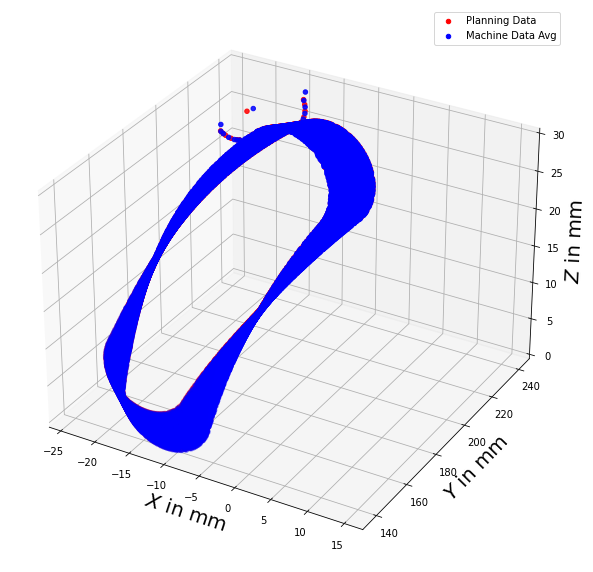

In [9]:
# Plot to show clusters
xdata, ydata, zdata = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

for i in np.arange(len(pltlst)):
    xdata[i] = tool_tip_X[pltlst[i]]
    ydata[i] = tool_tip_Y[pltlst[i]]
    zdata[i] = tool_tip_Z[pltlst[i]]

ax.scatter3D(xdata, ydata, zdata, color = 'red',label = 'Planning Data')
ax.legend()

xdata2, ydata2, zdata2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

for i in np.arange(len(pltlst)):
    xdata2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    ydata2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    zdata2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])

ax.scatter3D(xdata2, ydata2, zdata2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

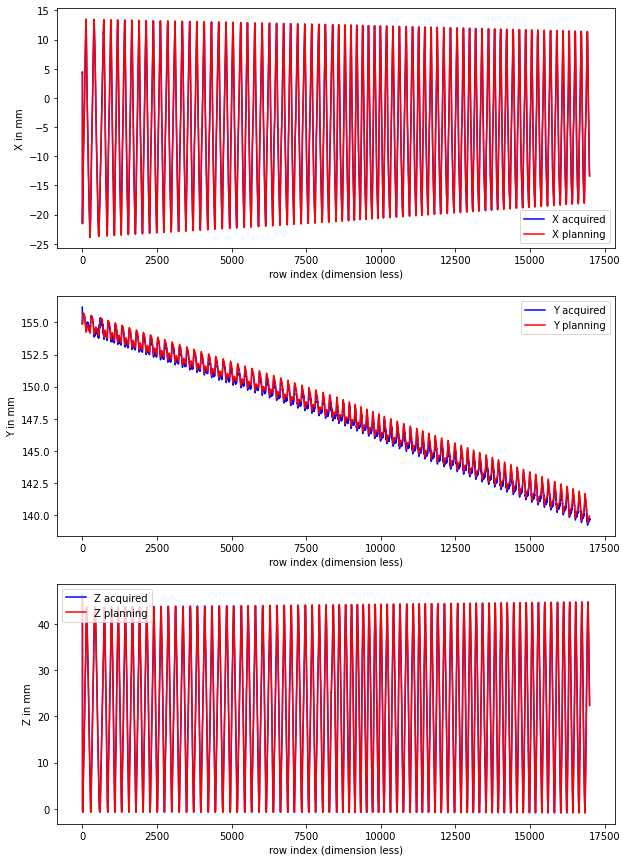

In [10]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(0,17000,xdata2,ydata2,zdata2,xdata,ydata,zdata)

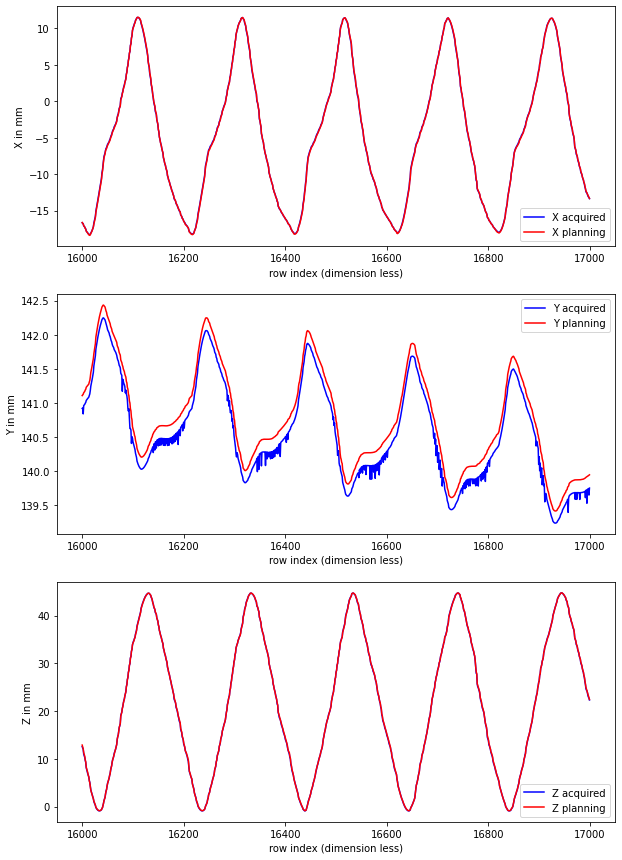

In [11]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(16000,17000,xdata2,ydata2,zdata2,xdata,ydata,zdata)

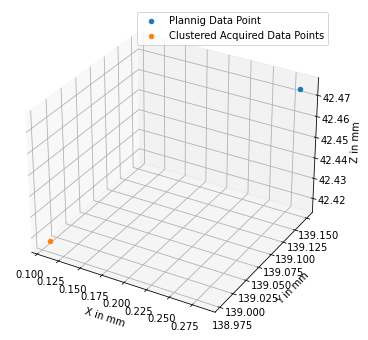

In [12]:
num = -10
xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)

plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]],label='Plannig Data Point')

for i in np.arange(len(lst3[pltlst[num]])):
    xdata[i] = X[lst3[pltlst[num]]][i]
    ydata[i] = Y[lst3[pltlst[num]]][i]
    zdata[i] = Z[lst3[pltlst[num]]][i]
    
ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
ax.set_xlabel('X in mm', fontsize=10)
ax.set_ylabel('Y in mm', fontsize=10)
ax.set_zlabel('Z in mm', fontsize=10)
plt.legend()

Input two numbers between 0 and 17496 with small difference for plots exaple 10000 then 10010
0


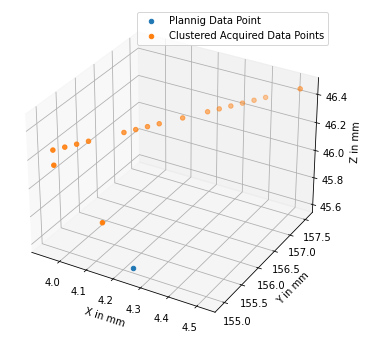

In [13]:
#for num in np.arange(len(pltlst)):
print('Input two numbers between 0 and {} with small difference for plots exaple 10000 then 10010'.format(len(pltlst)))
#lim1 = input()
#lim2 = input()

lim1 = 0
lim2 = 1

for num in np.arange(len(pltlst[int(lim1):int(lim2)])):
    xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)
    
    fig = plt.figure(figsize=(6,6))
    print(num)
    ax = plt.axes(projection='3d')

    ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]], label='Plannig Data Point')

    for i in np.arange(len(lst3[pltlst[num]])):
        xdata[i] = X[lst3[pltlst[num]]][i]
        ydata[i] = Y[lst3[pltlst[num]]][i]
        zdata[i] = Z[lst3[pltlst[num]]][i]
    
    ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
    ax.set_xlabel('X in mm', fontsize=10)
    ax.set_ylabel('Y in mm', fontsize=10)
    ax.set_zlabel('Z in mm', fontsize=10)
    plt.legend()
    plt.pause(0.1)
   

In [14]:
# for the clusterd points the acquired points are averaged
lst4 = []
for i in np.arange(len(lst3)):
    lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))

mean_m = pd.concat(lst4,axis=1).T
mean_m.iloc[0:1]

DynamicData     McX  DynamicData     McY  DynamicData     McZ  \
0                  NaN                  NaN                  NaN   

   DynamicData     Mc4th  DynamicData     Mc5th  DynamicData     Spindle Load  \
0                    NaN                    NaN                           NaN   

   DynamicData     Time Stamp  DynamicData     CurrentX  \
0                         NaN                       NaN   

   DynamicData     CurrentY  DynamicData     CurrentZ  \
0                       NaN                       NaN   

   DynamicData     Current4th  DynamicData     Current5th  \
0                         NaN                         NaN   

   DynamicData     WcX  DynamicData     WcY  DynamicData     WcZ  \
0                  NaN                  NaN                  NaN   

   DynamicData     Wc4th  DynamicData     Wc5th  Statistics-Fx     Mean  \
0                    NaN                    NaN                     NaN   

   Statistics-Fx     Std  Statistics-Fx     Max  Statistics-Fx     Min  \
0                    NaN                    NaN                    NaN   

   Statistics-Fy     Mean  Statistics-Fy     Std  Statistics-Fy     Max  \
0                     NaN                    NaN                    NaN   

   Statistics-Fy     Min  Statistics-Fz     Mean  Statistics-Fz     Std  \
0                    NaN                     NaN                    NaN   

   Statistics-Fz     Max  Statistics-Fz     Min  Statistics-Mz     Mean  \
0                    NaN                    NaN                     NaN   

   Statistics-Mz     Std  Statistics-Mz     Max  Statistics-Mz     Min  \
0                    NaN                    NaN                    NaN   

   Statistics-AccX     Mean  Statistics-AccX     Std  Statistics-AccX     Max  \
0                       NaN                      NaN                      NaN   

   Statistics-AccX     Min  Statistics-AccY     Mean  Statistics-AccY     Std  \
0                      NaN                       NaN                      NaN   

   Statistics-AccY     Max  Statistics-AccY     Min  Statistics-AccZ     Mean  \
0                      NaN                      NaN                       NaN   

   Statistics-AccZ     Std  Statistics-AccZ     Max  Statistics-AccZ     Min  
0                      NaN                      NaN                      NaN

In [15]:
# distances are averaged
tcp_avg = [(lambda x: sum(x)/len(x))(item) if len(item)!=0 else np.nan for item in tcp_val]
len(tcp_avg)
#tcp_avg

31092

In [16]:
# Now the final dataframe with plannind data and the corresponding averaged acquired data is obtained 
final_df = pd.concat([df_p,mean_m, pd.DataFrame({'tcp_error':tcp_avg})], axis=1)
#final_df = final_df.drop(['Level','Step'],axis=1)
final_df = final_df.dropna()
print(final_df.shape)
final_df.iloc[0:10]

(14607, 57)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
10       4.408467   154.896652    45.058876  0.230558  0.968651  0.092513   
14       4.456730   154.870407    44.303917  0.230558  0.968651  0.092513   
18       4.314739   154.856323    43.560532  0.230558  0.968651  0.092513   
22       3.991534   154.855316    42.876049  0.230558  0.968651  0.092513   
177    -21.444109   154.934113     0.436844 -0.342177  0.938093 -0.053822   
179    -21.104435   154.989197     0.210410 -0.338490  0.939295 -0.056122   
183    -20.379301   155.099487    -0.170577 -0.330442  0.941915 -0.060037   
185    -19.998171   155.153717    -0.322900 -0.326101  0.943322 -0.061658   
187    -19.607723   155.206757    -0.448454 -0.321562  0.944786 -0.063061   
189    -19.210207   155.258377    -0.545971 -0.316841  0.946300 -0.064251   

     Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
10     -0.716276     1.504966         7.512471       159.999199   
14     -1.096230     1.504535         7.511691       159.999263   
18     -1.182912     1.504219         7.510910       159.999327   
22     -1.224058     1.503978         7.510129       159.999391   
177    -1.239680     1.530632       -20.229243       161.779289   
179    -1.238178     1.526410       -20.183741       161.712364   
183    -1.230514     1.517567       -20.083076       161.564788   
185    -1.233770     1.514571       -20.031810       161.493833   
187    -1.225669     1.509704       -19.973963       161.409775   
189    -1.216391     1.504699       -19.913759       161.322683   

     Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
10         37.389226           -31.538500          -119.916298   
14         37.388707           -31.551600          -119.165901   
18         37.388187           -31.750700          -118.446602   
22         37.387667           -32.123299          -117.804298   
177         4.987927            33.010700           -98.220901   
179         4.974419            32.200699           -98.551804   
183         4.950521            31.886000           -98.644897   
185         4.940656            31.548401           -98.732300   
187         4.932145            31.187700           -98.815498   
189         4.925203            30.803699           -98.895599   

     DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
10           -210.059402             265.611603             -84.691803   
14           -210.155106             265.611603             -84.691803   
18           -210.279404             265.611603             -84.691803   
22           -210.424393             265.611603             -84.691803   
177          -225.697998             299.106598             -93.040604   
179          -226.099899             298.411896             -93.409401   
183          -226.186295             298.153809             -93.506500   
185          -226.249802             297.883698             -93.591003   
187          -226.291199             297.602295             -93.663200   
189          -226.311295             297.310486             -93.723396   

     DynamicData     Spindle Load  DynamicData     Time Stamp  \
10                      10.018182                3.707194e+09   
14                      10.040909                3.707194e+09   
18                      10.045455                3.707194e+09   
22                      10.050000                3.707194e+09   
177                      9.890909                3.707194e+09   
179                      9.863636                3.707194e+09   
183                      9.854546                3.707194e+09   
185                      9.854546                3.707194e+09   
187                      9.836364                3.707194e+09   
189                      9.836364                3.707194e+09   

     DynamicData     CurrentX  DynamicData     CurrentY  \
10                        0.0                       4.0   
14                        0.0              

In [17]:
final_df['block'] = block
final_df['angle'] = angle

In [18]:
print(final_df.shape)
final_df.iloc[0:10]

(14607, 59)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
10       4.408467   154.896652    45.058876  0.230558  0.968651  0.092513   
14       4.456730   154.870407    44.303917  0.230558  0.968651  0.092513   
18       4.314739   154.856323    43.560532  0.230558  0.968651  0.092513   
22       3.991534   154.855316    42.876049  0.230558  0.968651  0.092513   
177    -21.444109   154.934113     0.436844 -0.342177  0.938093 -0.053822   
179    -21.104435   154.989197     0.210410 -0.338490  0.939295 -0.056122   
183    -20.379301   155.099487    -0.170577 -0.330442  0.941915 -0.060037   
185    -19.998171   155.153717    -0.322900 -0.326101  0.943322 -0.061658   
187    -19.607723   155.206757    -0.448454 -0.321562  0.944786 -0.063061   
189    -19.210207   155.258377    -0.545971 -0.316841  0.946300 -0.064251   

     Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
10     -0.716276     1.504966         7.512471       159.999199   
14     -1.096230     1.504535         7.511691       159.999263   
18     -1.182912     1.504219         7.510910       159.999327   
22     -1.224058     1.503978         7.510129       159.999391   
177    -1.239680     1.530632       -20.229243       161.779289   
179    -1.238178     1.526410       -20.183741       161.712364   
183    -1.230514     1.517567       -20.083076       161.564788   
185    -1.233770     1.514571       -20.031810       161.493833   
187    -1.225669     1.509704       -19.973963       161.409775   
189    -1.216391     1.504699       -19.913759       161.322683   

     Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
10         37.389226           -31.538500          -119.916298   
14         37.388707           -31.551600          -119.165901   
18         37.388187           -31.750700          -118.446602   
22         37.387667           -32.123299          -117.804298   
177         4.987927            33.010700           -98.220901   
179         4.974419            32.200699           -98.551804   
183         4.950521            31.886000           -98.644897   
185         4.940656            31.548401           -98.732300   
187         4.932145            31.187700           -98.815498   
189         4.925203            30.803699           -98.895599   

     DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
10           -210.059402             265.611603             -84.691803   
14           -210.155106             265.611603             -84.691803   
18           -210.279404             265.611603             -84.691803   
22           -210.424393             265.611603             -84.691803   
177          -225.697998             299.106598             -93.040604   
179          -226.099899             298.411896             -93.409401   
183          -226.186295             298.153809             -93.506500   
185          -226.249802             297.883698             -93.591003   
187          -226.291199             297.602295             -93.663200   
189          -226.311295             297.310486             -93.723396   

     DynamicData     Spindle Load  DynamicData     Time Stamp  \
10                      10.018182                3.707194e+09   
14                      10.040909                3.707194e+09   
18                      10.045455                3.707194e+09   
22                      10.050000                3.707194e+09   
177                      9.890909                3.707194e+09   
179                      9.863636                3.707194e+09   
183                      9.854546                3.707194e+09   
185                      9.854546                3.707194e+09   
187                      9.836364                3.707194e+09   
189                      9.836364                3.707194e+09   

     DynamicData     CurrentX  DynamicData     CurrentY  \
10                        0.0                       4.0   
14                        0.0              

In [19]:
final_df = final_df.iloc[int(final_df.shape[0]*0.05):-int(final_df.shape[0]*0.05),:]

In [20]:
print(final_df.shape)
final_df.iloc[0:10]

(13147, 59)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
1759     -6.196227   154.179672    33.968010  0.044009  0.995099  0.088546   
1760     -6.477368   154.174866    33.672688  0.036786  0.995432  0.088100   
1761     -6.756725   154.169739    33.375793  0.029531  0.995715  0.087634   
1763     -7.309973   154.158707    32.777039  0.014940  0.996128  0.086641   
1764     -7.583929   154.152802    32.475212  0.007611  0.996256  0.086114   
1765     -7.856357   154.146683    32.172001  0.000266  0.996332  0.085568   
1766     -8.127068   154.140335    31.867222 -0.007092  0.996355  0.085003   
1768     -8.662901   154.127106    31.252588 -0.021833  0.996242  0.083816   
1775    -10.483998   154.076523    29.049446 -0.073273  0.994146  0.079406   
1776    -10.737498   154.069031    28.726923 -0.080556  0.993616  0.078980   

      Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
1759    -0.855170     1.483372        -1.912116       159.841167   
1760    -0.828396     1.482721        -2.209591       159.858451   
1761    -0.801133     1.482071        -2.504096       159.875405   
1763    -0.735496     1.479888        -3.099796       159.904612   
1764    -0.702045     1.478948        -3.395375       159.919793   
1765    -0.671548     1.478629        -3.682148       159.937883   
1766    -0.636621     1.478160        -3.984063       159.956201   
1768    -0.563176     1.476631        -4.552664       159.986361   
1775    -0.273366     1.472271        -6.532008       160.095464   
1776    -0.232960     1.471201        -6.795595       160.108572   

      Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
1759        30.093678             -12.1408          -109.506798   
1760        29.819141             -11.4568          -109.323303   
1761        29.544503             -10.7689          -109.141197   
1763        28.980402              -8.7415          -108.617302   
1764        28.695872              -7.3358          -108.264999   
1765        28.416665              -6.6295          -108.090599   
1766        28.119888              -6.2089          -108.106903   
1768        27.551648              -3.1301          -107.250298   
1775        25.477144               1.7482          -106.023102   
1776        25.188989               3.8822          -105.340202   

      DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
1759          -209.701706             276.894012             -84.970497   
1760          -209.706802             277.233490             -84.992302   
1761          -209.715897             277.573914             -85.014801   
1763          -209.765793             278.571899             -85.084801   
1764          -209.820999             279.259186             -85.136597   
1765          -209.854797             279.603394             -85.163399   
1766          -210.115906             279.799408             -85.203201   
1768          -210.083405             281.298401             -85.306000   
1775          -210.505707             283.640411             -85.495499   
1776          -210.654404             284.659485             -85.534599   

      DynamicData     Spindle Load  DynamicData     Time Stamp  \
1759                     10.050000                3.707194e+09   
1760                     10.050000                3.707194e+09   
1761                     10.050000                3.707194e+09   
1763                     10.040909                3.707194e+09   
1764                     10.031818                3.707194e+09   
1765                     10.040909                3.707194e+09   
1766                      9.904546                3.707194e+09   
1768                     10.036364                3.707194e+09   
1775                      9.950000                3.707194e+09   
1776                      9.931818                3.707194e+09   

      DynamicData     CurrentX  DynamicData     CurrentY  \
1759                       7.0                 

In [21]:
#block = 6030
#angle = 96-15
def test(final_df,block, angle):
    
    final_df = final_df
    block = block
    angle = angle

    tool_tip_X = final_df['X_TTP Q [mm]'].to_numpy()
    tool_tip_Y = final_df['Y_TTP  [mm]'].to_numpy()
    tool_tip_Z = final_df['Z_TTP  [mm]'].to_numpy()
    X_inv=tool_tip_X
    Y_inv=tool_tip_Y
    Z_inv=tool_tip_Z

    wcx = pd.to_numeric(final_df['DynamicData     WcX']).to_numpy()
    wcy = pd.to_numeric(final_df['DynamicData     WcY']).to_numpy()
    wcz = pd.to_numeric(final_df['DynamicData     WcZ']).to_numpy()

    size = wcx.shape[0]
    ones = np.ones((size,))
    zeros = np.zeros((size,))

    init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

    machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

    forward_transformation = np.transpose(init_C, (2,0,1))
    tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
    tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

    X = tool_position_workpiece_CS[0,0,:]
    Y = tool_position_workpiece_CS[1,0,:]
    Z = tool_position_workpiece_CS[2,0,:]
    
    subplotter(0,final_df.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)
    subplotter(0,1000,X,Y,Z,X_inv,Y_inv,Z_inv)
    
    plt.figure(figsize=(10,15))
    ax1 = plt.axes(projection='3d')
    ax1.set_zlim3d([0,30])

    ax1.set_xlabel('$X$ in mm', fontsize=20)
    ax1.set_ylabel('$Y$ in mm', fontsize=20)
    ax1.set_zlabel('$Z$ in mm', fontsize=20)

    ax1.scatter3D(X_inv, Y_inv, Z_inv, color = 'red',label = 'Planning Data')
    ax1.legend()

    ax1.scatter3D(X, Y, Z, color = 'blue',label = 'Machine Data Avg')
    ax1.legend()


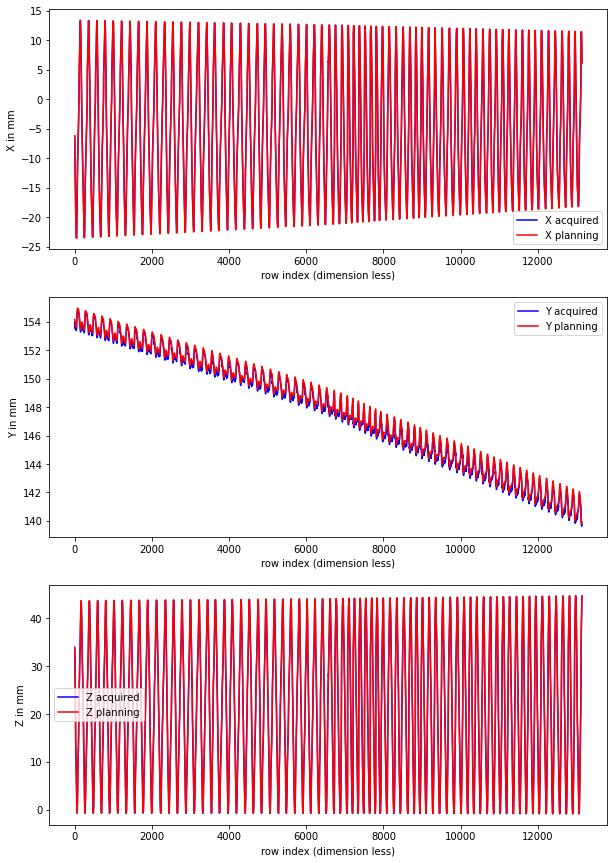

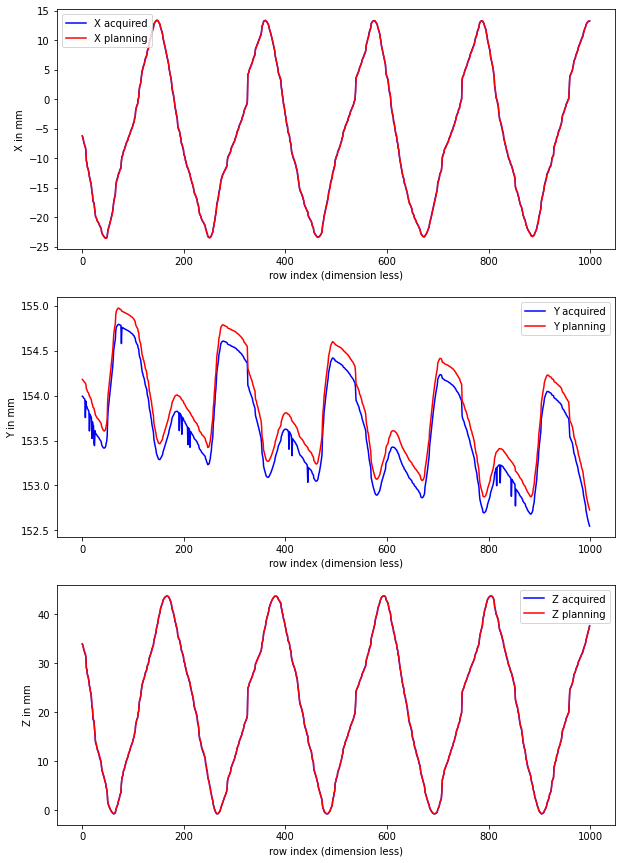

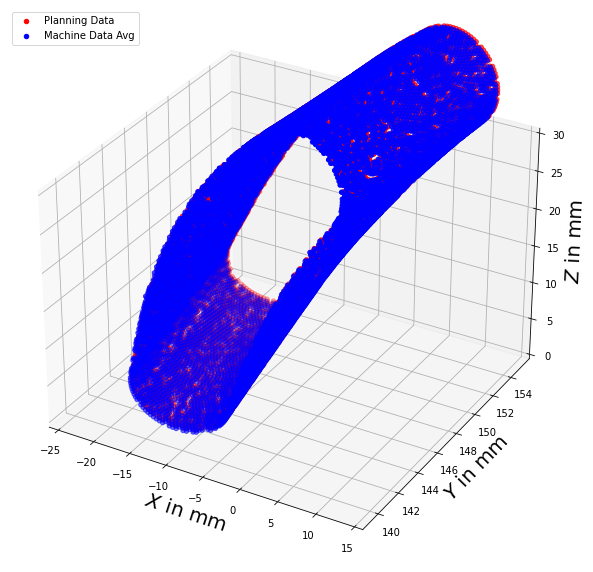

In [22]:
test(final_df, block, angle)

In [23]:
def shift(final_df, block, angle):
  
    final_df = final_df
    block = block
    angle = angle

    tool_tip_X = final_df['X_TTP Q [mm]'].to_numpy()
    tool_tip_Y = final_df['Y_TTP  [mm]'].to_numpy()
    tool_tip_Z = final_df['Z_TTP  [mm]'].to_numpy()
    
    X_inv_final=tool_tip_X
    Y_inv_final=tool_tip_Y
    Z_invfinal=tool_tip_Z

    wcx = pd.to_numeric(final_df['DynamicData     WcX']).to_numpy()
    wcy = pd.to_numeric(final_df['DynamicData     WcY']).to_numpy()
    wcz = pd.to_numeric(final_df['DynamicData     WcZ']).to_numpy()

    size = wcx.shape[0]
    ones = np.ones((size,))
    zeros = np.zeros((size,))

    init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

    machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

    forward_transformation = np.transpose(init_C, (2,0,1))
    tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
    tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

    X_final = tool_position_workpiece_CS[0,0,:]
    Y_final = tool_position_workpiece_CS[1,0,:]
    Z_final = tool_position_workpiece_CS[2,0,:]
    

    #Shifting the data 
    div = 20
    length = Y_final.shape[0]
    chunck_len = int(length/div)
    
    for i in np.arange(0,div):
        if(i != div-1):
            diff = Y_final[i*chunck_len:(i+1)*chunck_len] - Y_inv_final[i*chunck_len:(i+1)*chunck_len]
            Y_final[i*chunck_len:(i+1)*chunck_len] = Y_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff)

        else:
            diff = Y_final[i*chunck_len:length] - Y_inv_final[i*chunck_len:length]
            Y_final[i*chunck_len:length] = Y_final[i*chunck_len:length] - np.mean(diff)

        
    return X_final,Y_final,Z_final



In [24]:
X_mc, Y_mc, Z_mc = shift(final_df, block, angle)

In [25]:
final_df['Tool Tip Point Machine X'] = X_mc
final_df['Tool Tip Point Machine Y'] = Y_mc
final_df['Tool Tip Point Machine Z'] = Z_mc

In [26]:
print(final_df.shape)
final_df.iloc[0:10]

(13147, 62)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
1759     -6.196227   154.179672    33.968010  0.044009  0.995099  0.088546   
1760     -6.477368   154.174866    33.672688  0.036786  0.995432  0.088100   
1761     -6.756725   154.169739    33.375793  0.029531  0.995715  0.087634   
1763     -7.309973   154.158707    32.777039  0.014940  0.996128  0.086641   
1764     -7.583929   154.152802    32.475212  0.007611  0.996256  0.086114   
1765     -7.856357   154.146683    32.172001  0.000266  0.996332  0.085568   
1766     -8.127068   154.140335    31.867222 -0.007092  0.996355  0.085003   
1768     -8.662901   154.127106    31.252588 -0.021833  0.996242  0.083816   
1775    -10.483998   154.076523    29.049446 -0.073273  0.994146  0.079406   
1776    -10.737498   154.069031    28.726923 -0.080556  0.993616  0.078980   

      Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
1759    -0.855170     1.483372        -1.912116       159.841167   
1760    -0.828396     1.482721        -2.209591       159.858451   
1761    -0.801133     1.482071        -2.504096       159.875405   
1763    -0.735496     1.479888        -3.099796       159.904612   
1764    -0.702045     1.478948        -3.395375       159.919793   
1765    -0.671548     1.478629        -3.682148       159.937883   
1766    -0.636621     1.478160        -3.984063       159.956201   
1768    -0.563176     1.476631        -4.552664       159.986361   
1775    -0.273366     1.472271        -6.532008       160.095464   
1776    -0.232960     1.471201        -6.795595       160.108572   

      Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
1759        30.093678             -12.1408          -109.506798   
1760        29.819141             -11.4568          -109.323303   
1761        29.544503             -10.7689          -109.141197   
1763        28.980402              -8.7415          -108.617302   
1764        28.695872              -7.3358          -108.264999   
1765        28.416665              -6.6295          -108.090599   
1766        28.119888              -6.2089          -108.106903   
1768        27.551648              -3.1301          -107.250298   
1775        25.477144               1.7482          -106.023102   
1776        25.188989               3.8822          -105.340202   

      DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
1759          -209.701706             276.894012             -84.970497   
1760          -209.706802             277.233490             -84.992302   
1761          -209.715897             277.573914             -85.014801   
1763          -209.765793             278.571899             -85.084801   
1764          -209.820999             279.259186             -85.136597   
1765          -209.854797             279.603394             -85.163399   
1766          -210.115906             279.799408             -85.203201   
1768          -210.083405             281.298401             -85.306000   
1775          -210.505707             283.640411             -85.495499   
1776          -210.654404             284.659485             -85.534599   

      DynamicData     Spindle Load  DynamicData     Time Stamp  \
1759                     10.050000                3.707194e+09   
1760                     10.050000                3.707194e+09   
1761                     10.050000                3.707194e+09   
1763                     10.040909                3.707194e+09   
1764                     10.031818                3.707194e+09   
1765                     10.040909                3.707194e+09   
1766                      9.904546                3.707194e+09   
1768                     10.036364                3.707194e+09   
1775                      9.950000                3.707194e+09   
1776                      9.931818                3.707194e+09   

      DynamicData     CurrentX  DynamicData     CurrentY  \
1759                       7.0                 

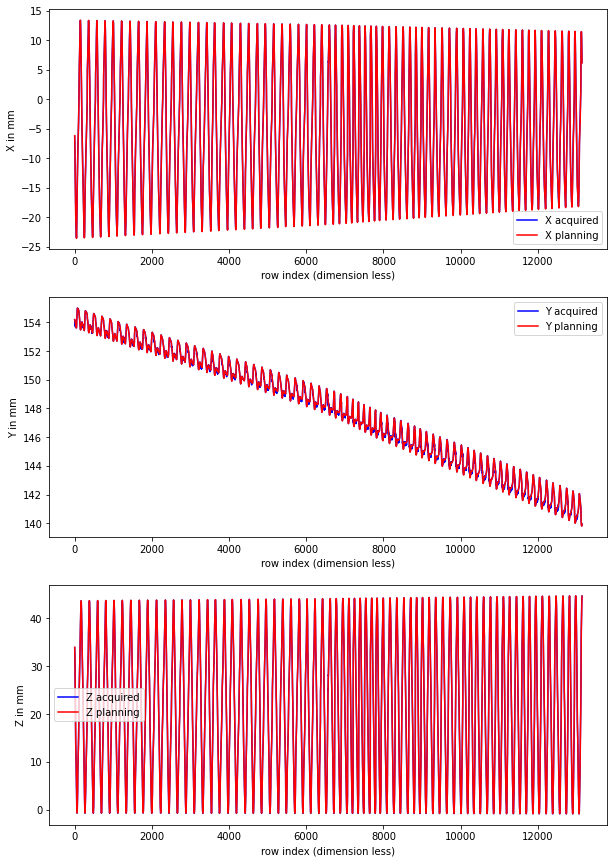

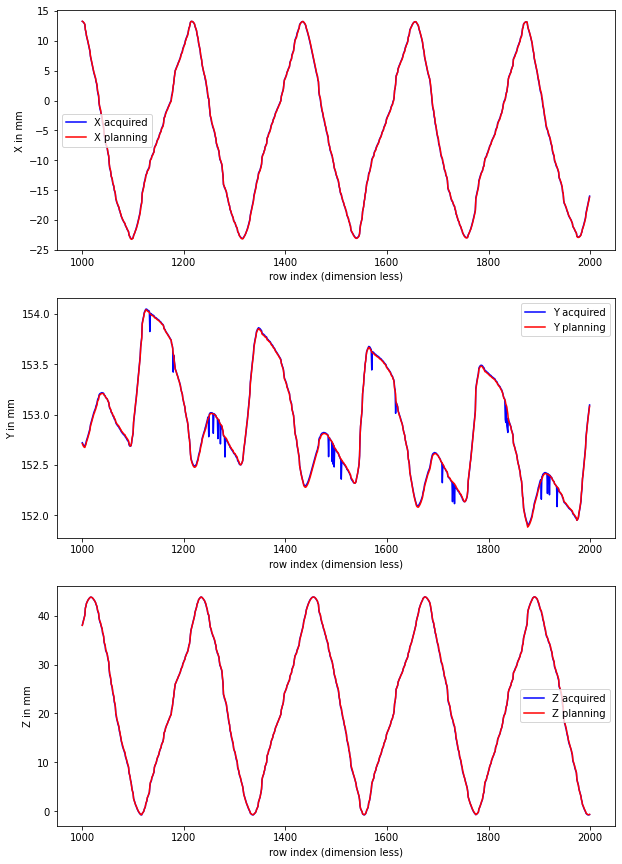

In [27]:
subplotter(0,final_df.shape[0],final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())
subplotter(1000,2000,final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())

In [28]:
Y_tpm = final_df['Tool Tip Point Machine Y'].to_numpy()
Y_ref = final_df['Y_TTP  [mm]'].to_numpy()

col = final_df.columns
diff = Y_tpm - Y_ref

del_pos = np.where(abs(diff)>0.1)[0]#

arr = final_df.to_numpy()
arr = np.delete(arr,del_pos, 0)

final_df = pd.DataFrame(arr,columns=col)

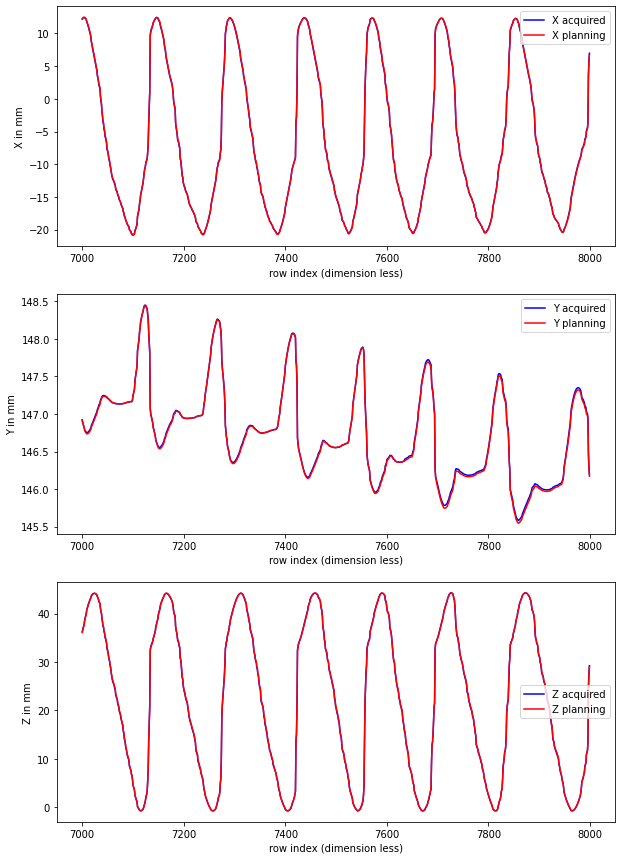

In [29]:
subplotter(7000,8000,final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())

0.13639551647474202


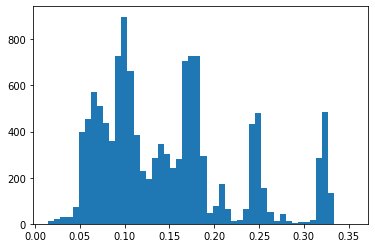

In [30]:
#tool point deviation

tool_point_deviation = np.sqrt(((final_df['Tool Tip Point Machine X'] - final_df['X_TTP Q [mm]'])**2 + (final_df['Tool Tip Point Machine Y'] - final_df['Y_TTP  [mm]'])**2 + (final_df['Tool Tip Point Machine Z'] - final_df['Z_TTP  [mm]'])**2).to_numpy(dtype=np.float64))
X_deviation = (final_df['Tool Tip Point Machine X'] - final_df['X_TTP Q [mm]']).to_numpy()
Y_deviation = (final_df['Tool Tip Point Machine Y'] - final_df['Y_TTP  [mm]']).to_numpy()
Z_deviation = (final_df['Tool Tip Point Machine Z'] - final_df['Z_TTP  [mm]']).to_numpy()

print(np.median(tool_point_deviation))
plt.hist(tool_point_deviation, bins=50)
plt.show()
final_df['Tool Point Deviation'] = tool_point_deviation
final_df['X_tool_path_deviation'] = X_deviation
final_df['Y_tool_path_deviation'] = Y_deviation
final_df['Z_tool_path_deviation'] = Z_deviation


In [31]:
final_df.describe()

X_TTP Q [mm]   Y_TTP  [mm]   Z_TTP  [mm]      I  [rad]      J  [rad]  \
count  12479.000000  12479.000000  12479.000000  12479.000000  12479.000000   
mean      -5.579891    147.963366     21.436990     -0.050239      0.966422   
std       10.870617      3.998610     14.994081      0.244048      0.023741   
min      -23.588478    139.806213     -0.835091     -0.391294      0.920169   
25%      -15.353405    144.479515      7.767313     -0.297961      0.951597   
50%       -6.833962    148.408875     20.749544     -0.058320      0.965813   
75%        4.431715    151.438622     35.318008      0.217511      0.988966   
max       13.364147    154.975266     44.731579      0.294676      0.999923   

           K  [rad]   Lead  [rad]   Tilt  [rad]  X_Contact  [mm]  \
count  12479.000000  12479.000000  12479.000000     12479.000000   
mean       0.025353     -0.138818      1.468877        -5.816797   
std        0.052376      0.856256      0.049893         9.848382   
min       -0.073934     -1.429867      1.361470       -20.246102   
25%       -0.019687     -0.926782      1.434638       -14.989932   
50%        0.046302     -0.257541      1.467328        -8.021041   
75%        0.070379      0.499775      1.500049         5.286696   
max        0.092339      1.599995      1.573106         9.196308   

       Y_Contact  [mm]  Z_Contact  [mm]  DynamicData     McX  \
count     12479.000000     12479.000000         12479.000000   
mean        153.968521        21.588063             2.213265   
std           4.037768        12.988440            26.149092   
min         145.255055         4.812074           -34.444801   
25%         150.495590         8.080019           -27.174801   
50%         154.510571        20.845805             1.723300   
75%         157.424552        35.769764            29.916700   
max         161.438320        39.132662            38.542500   

       DynamicData     McY  DynamicData     McZ  DynamicData     Mc4th  \
count         12479.000000         12479.000000           12479.000000   
mean           -107.318766          -224.493138             282.017296   
std              10.049609             7.104571              14.214085   
min            -125.809196          -241.413193             261.843201   
25%            -116.077049          -229.390251             266.579498   
50%            -106.414101          -223.774902             282.390503   
75%             -98.745350          -219.367302             296.389801   
max             -89.331200          -209.701706             302.050415   

       DynamicData     Mc5th  DynamicData     Spindle Load  \
count           12479.000000                  12479.000000   
mean              -88.567629                      9.925892   
std                 2.998294                      0.103657   
min               -94.239197                      9.609091   
25%               -91.154400                      9.850000   
50%               -87.362602                      9.927273   
75%               -85.988701                     10.004545   
max               -84.725304                     10.218182   

       DynamicData     Time Stamp  DynamicData     CurrentX  \
count                1.247900e+04              12479.000000   
mean                 3.707194e+09                 -0.188236   
std                  6.962873e+01                  4.252177   
min                  3.707194e+09                -10.000000   
25%                  3.707194e+09                 -3.000000   
50%                  3.707194e+09                  0.000000   
75%                  3.707194e+09                  2.000000   
max                  3.707194e+09                  8.000000   

       DynamicData     CurrentY  DynamicData     CurrentZ  \
count              12479.000000              12479.000000   
mean                  -1.695809                 45.662954   
std                   10.691177                 11.232439   
min                  -36.000000                 19.000000   
25%   

In [32]:
final_df.iloc[0:100]

X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
0      -6.196227   154.179672    33.968010  0.044009  0.995099  0.088546   
1      -6.477368   154.174866    33.672688  0.036786  0.995432  0.088100   
2      -6.756725   154.169739    33.375793  0.029531  0.995715  0.087634   
3      -7.309973   154.158707    32.777039  0.014940  0.996128  0.086641   
4      -7.583929   154.152802    32.475212  0.007611  0.996256  0.086114   
5      -7.856357   154.146683    32.172001  0.000266  0.996332  0.085568   
6      -8.662901   154.127106    31.252588 -0.021833  0.996242  0.083816   
7     -10.483998   154.076523    29.049446 -0.073273  0.994146  0.079406   
8     -10.737498   154.069031    28.726923 -0.080556  0.993616  0.078980   
9     -11.487780   154.046494    27.746206 -0.102239  0.991681  0.078206   
10    -11.734506   154.038986    27.415112 -0.109398  0.990925  0.078097   
11    -11.979720   154.031479    27.081997 -0.116512  0.990117  0.078064   
12    -12.465443   154.016541    26.409475 -0.130646  0.988332  0.078299   
13    -13.416419   153.987442    25.038712 -0.158424  0.984143  0.079773   
14    -13.883189   153.973083    24.342358 -0.172002  0.981770  0.080894   
15    -14.113992   153.966049    23.991283 -0.178699  0.980521  0.081525   
16    -14.797976   153.945114    22.928570 -0.198374  0.976554  0.083607   
17    -16.124186   153.905106    20.761110 -0.235518  0.967880  0.087970   
18    -17.194082   153.871689    18.923466 -0.263770  0.960297  0.090857   
19    -17.403967   153.865051    18.552807 -0.269086  0.958782  0.091264   
20    -19.039595   153.810028    15.562448 -0.307231  0.947251  0.091237   
21    -19.827583   153.781342    14.056428 -0.323490  0.942106  0.088262   
22    -20.022230   153.773712    13.680131 -0.327244  0.940914  0.087130   
23    -20.215948   153.765945    13.303954 -0.330867  0.939766  0.085827   
24    -20.598679   153.750626    12.550174 -0.337706  0.937613  0.082681   
25    -20.716438   153.745667    12.317963 -0.339707  0.936989  0.081559   
26    -20.812105   153.741852    12.126264 -0.341309  0.936491  0.080579   
27    -20.979080   153.734818    11.792344 -0.344011  0.935658  0.078741   
28    -21.166096   153.726730    11.415660 -0.346921  0.934771  0.076474   
29    -21.352306   153.718246    11.039498 -0.349677  0.933944  0.073993   
30    -21.537643   153.709518    10.663589 -0.352277  0.933177  0.071288   
31    -21.722057   153.700409    10.288281 -0.354715  0.932473  0.068354   
32    -21.905674   153.690964     9.913514 -0.356988  0.931832  0.065182   
33    -22.452204   153.660583     8.793283 -0.362773  0.930302  0.054164   
34    -22.791155   153.640106     8.094546 -0.365567  0.929646  0.046031   
35    -22.923849   153.631195     7.825645 -0.366481  0.929450  0.042600   
36    -23.141705   153.616333     7.362565 -0.367803  0.929194  0.036323   
37    -23.228355   153.611191     7.151499 -0.368291  0.929112  0.033351   
38    -23.366730   153.605804     6.748960 -0.369028  0.929009  0.027576   
39    -23.503616   153.609146     6.169939 -0.369662  0.928969  0.019121   
40    -23.558975   153.616791     5.793171 -0.369830  0.929001  0.013502   
41    -23.588478   153.628525     5.418899 -0.369836  0.929064  0.007837   
42    -23.573433   153.663788     4.669207 -0.369307  0.929301 -0.003455   
43    -23.527853   153.687469     4.294401 -0.368766  0.929479 -0.008928   
44    -23.359217   153.746735     3.550321 -0.367128  0.929974 -0.019086   
45    -22.506706   153.950470     1.802671 -0.358605  0.932637 -0.039891   
46    -22.136015   154.023880     1.333338 -0.354796  0.933863 -0.044946   
47    -21.860952   154.075272     1.040274 -0.351943  0.934789 -0.048021   
48    -21.564569   154.128250     0.765291 -0.348843  0.935800 -0.050862   
49    -21.248373   154.182358     0.510074 -0.345501  0.936894 -0.053471   
50    -20.914143   154.237030     0.276091 -0.341920  0.938068 -0.055850   
51    -20.563686   154.291855     0.064645 -0.338109